# Setting GPU

In [1]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [2]:
import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## (Almost) Reproducible results

In [3]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)
# session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/student

In [4]:
# import tensorflow as tf
# tf.test.is_built_with_cuda()

In [5]:
# from keras import backend as K
# import tensorflow as tf
# # import os
# # with tf.device("/GPU:0"):
# # os.environ["CUDA_VISIBLE_DEVICES"]="0"
# K.tensorflow_backend._get_available_gpus()

In [6]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# # gpus = tf.config.experimental.list_physical_devices('GPU')
# # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# device_lib.list_local_devices()

In [7]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

# Setting for training

In [8]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [9]:
import keras
keras.__version__

'2.3.1'

## Load Dataset and count zero's

In [10]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*len(x[0])*2 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

## Data preprocessing functions

In [11]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
    return [0.0,0.0] #in case that point is never found in the video
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    notFoundPoints = set()
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            if pointIdx in notFoundPoints:
                videoFeatures[frameIdx][pointIdx] = [0.0,0.0]
            else:
                videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)
            
            if np.count_nonzero(videoFeatures[frameIdx][pointIdx]) == 0:
                notFoundPoints.add(pointIdx)

In [12]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels, encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
         maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    # 17 if there is always only 1 person, 34 if there are videos with 2 people
    maxVideoHeigth = max([len(s[0]) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    for dataset in [X_train, X_val, X_test]:
        for i in range(len(dataset)):
            if dataset[i].shape[1] < maxVideoHeigth:
                videoShape = dataset[i].shape
                missingPart = (videoShape[0], maxVideoHeigth-videoShape[1], videoShape[2])
#                 dataset[i] = np.concatenate((dataset[i],np.zeros(dataset[i].shape)),axis=1)
                dataset[i] = np.concatenate((dataset[i], np.zeros(missingPart)), axis=1)
    
    
    X_train = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_val = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_test = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([X_train, X_val, X_test]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return X_train, X_val, X_test

In [13]:
# def normaliseBeforePadding(X_train, X_val, X_test):
#     print("!!!! That's not correct. It normalize the datasets all in one. You should normalize each video indipendently.")
#     trainAndVal = np.concatenate((X_train, X_val), axis=0)
#     print("normalising train, val and test values BEFORE padding")
#     trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
#     trainStd = np.vstack(trainAndVal).std()
#     normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
#     normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
#     normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])

#     return normalized_X_train, normalized_X_val, normalized_X_test

In [14]:
def normalizeVideosXYInpid(dataset):
    print("normalising EACH VIDEO, considering x and y INDIPENDENTLY")

    for i in range(len(dataset)):
        xAndYVideoMean = np.mean(np.vstack(dataset[i]),axis=0)
        xAndYVideoStd = np.std(np.vstack(dataset[i]),axis=0)
        dataset[i] = (dataset[i]-xAndYVideoMean)/xAndYVideoStd

    return dataset

In [15]:
def normalizeVideos(dataset):
    print("normalising EACH VIDEO, considering x and y TOGETHER")
    for i in range(len(dataset)):
        videoMean = np.mean(np.vstack(dataset[i]))
        videoStd = np.std(np.vstack(dataset[i]))
        dataset[i] = (dataset[i]-videoMean)/videoStd

    return dataset

In [16]:
# Posenet predicts:
# 1 - nose             18
# 2 - leftEye          19
# 3 - rightEye         20
# 4 - leftEar          21
# 5 - rightEar         22

# 6 - leftShoulder     23
# 7 - rightShoulder    24
# 8 - leftElbow        25
# 9 - rightElbow       26
# 10 - leftWrist       27
# 11 - rightWrist      28

# 12 - leftHip         29
# 13 - rightHip        30
# 14 - leftKnee        31
# 15 - rightKnee       32
# 16 - leftAnkle       33
# 17 - rightAnkle      34

In [17]:
def relativeToVideoCenter(X):
    print("Adapting the data to the CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

def relativeToPersonVideoCenter(X):
    print("Adapting the data to the video PERSON CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features[:17],axis=0) for features in frames], axis = 0) 

        if len(frames[0]) == 34:
            videoMean2 = np.mean([np.mean(features[17:],axis=0) for features in frames], axis = 0) 
            videoMean = np.vstack((videoMean, videoMean2)) 
            videoMean = np.repeat(videoMean, [17, 17], axis=0)
        
        X[i] = [frame-videoMean for frame in frames]

    return X

In [18]:
def relativeToFrameCenter(X):
    print("Adapting the data to the CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

def relativeToPersonFrameCenter(X):
    print("Adapting the data to the PERSON CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame[:17],axis=0)
            if len(frame) == 34:
                frame_mean2 = np.mean(frame[17:],axis=0)
                frame_mean = np.vstack((frame_mean, frame_mean2)) 
                frame_mean = np.repeat(frame_mean, [17, 17], axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [19]:
# [[[p[0]+i, p[1]+i]for i,p in enumerate(f)] for f in X_to_test1]

In [20]:
# PER PERSON BARICENTERS
def relativeTo5PersonalBaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body PERSONAL BARICENTERS of each video as in NTU-RGB+D")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        for person_offset in range(0,len(frames[0]),17):
            troncoPoints = [i+person_offset for i in troncoPoints]
            rightArmPoints = [i+person_offset for i in rightArmPoints]
            leftArmPoints = [i+person_offset for i in leftArmPoints]
            rightLegPoints = [i+person_offset for i in rightLegPoints]
            leftLegPoints = [i+person_offset for i in leftLegPoints]
            troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
            rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
            leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
            rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
            leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

            videoCenterFrame[troncoPoints] = troncoCenter 
            videoCenterFrame[rightArmPoints] = rightArmCenter 
            videoCenterFrame[leftArmPoints] = leftArmCenter 
            videoCenterFrame[rightLegPoints] = rightLegCenter 
            videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X


# GLOBAL BARICENTERS
def relativeTo5GlobalBaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body GLOBAL BARICENTERS of each video as in NTU-RGB+D")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        if len(frames[0]) == 34:
            person_offset = 17
            troncoPoints += [i+person_offset for i in troncoPoints]
            rightArmPoints += [i+person_offset for i in rightArmPoints]
            leftArmPoints += [i+person_offset for i in leftArmPoints]
            rightLegPoints += [i+person_offset for i in rightLegPoints]
            leftLegPoints += [i+person_offset for i in leftLegPoints]
        troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
        rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
        leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
        rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
        leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

        videoCenterFrame[troncoPoints] = troncoCenter 
        videoCenterFrame[rightArmPoints] = rightArmCenter 
        videoCenterFrame[leftArmPoints] = leftArmCenter 
        videoCenterFrame[rightLegPoints] = rightLegCenter 
        videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X

def relativeTo5GlobalBaricentersNTURGBofVideoAbs(X):
    print("ABSOLUTE VALUES of 5 GLOBAL BARICENTERS")
    return abs(relativeTo5GlobalBaricentersNTURGBofVideo(X))

def relativeTo5PersonalBaricentersNTURGBofVideoAbs(X):
    print("ABSOLUTE VALUES of 5 PERSONAL BARICENTERS")
    return abs(relativeTo5PersonalBaricentersNTURGBofVideo(X)) 

In [21]:
# # model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
# datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_TEST-dataset.pickle"

# train_set, val_set, test_set = getData(datasetName)

# train_set[0] = removeZerosFromDataset(train_set[0])
# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))

    
# X_to_test = train_set[0][0]
# X_to_test = X_to_test[:2]
# X_to_test = np.expand_dims(X_to_test, axis=0)
# print("X_to_test shape", X_to_test.shape)

In [22]:
# def relativeTo3BaricentersOfFrame(X):
#     assert False, "Va testato"
#     print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
#     for i_video, video in enumerate(X):
#         for i_frame, frame in enumerate(video):
#             X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
#             X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
#             X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
#             if len(frame) == 34:
#                 X[i_video][i_frame][17:22] = frame[17:22] - np.mean(frame[17:22], axis=0)
#                 X[i_video][i_frame][22:28] = frame[22:28] - np.mean(frame[22:28], axis=0)
#                 X[i_video][i_frame][28:34] = frame[28:34] - np.mean(frame[28:34], axis=0)
#     return X

In [23]:
# #ARTIFICIAL 
# X_to_test1 = np.ones(2*17*2).reshape((2,17,2)) # 1 person
# X_to_test1 = np.asarray([np.asarray([np.asarray([p[0]+i, p[1]+i]) for i,p in enumerate(f)]) for f in X_to_test1])

# X_to_test2 = np.ones(3*34*2).reshape((3,34,2)) # 2 people
# X_to_test2 = np.asarray([np.asarray([np.asarray([p[0]+i+100, p[1]+i+100]) for i,p in enumerate(f)]) for f in X_to_test2])

# # X_to_test3 = np.ones(3*17*2).reshape((3,17,2)) # 1 person
# # X_to_test3 = np.asarray([np.asarray([np.asarray([p[0]+i+200, p[1]+i+200]) for i,p in enumerate(f)]) for f in X_to_test3])

# # X_to_test = np.asarray([X_to_test1, X_to_test2, X_to_test3])
# X_to_test = np.asarray([X_to_test1, X_to_test2])

# print(X_to_test)
# print(relativeTo3GlobalBaricentersOfVideo(X_to_test))




In [24]:
def relativeTo3PersonalBaricentersOfVideo(X):
    print("Adapting the data wrt to the 3 PERSONAL BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        videoUpperMeanP1 = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMeanP1 = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMeanP1 = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            videoUpperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            videoMiddleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            videoBottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMeanP1
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMeanP1
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMeanP1
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - videoUpperMeanP2
                X[i_video][i_frame][22:28] = frame[22:28] - videoMiddleMeanP2
                X[i_video][i_frame][28:34] = frame[28:34] - videoBottomMeanP2
                
    return X

def relativeTo3GlobalBaricentersOfVideo(X):
    print("Adapting the data wrt to the 3 GLOBAL BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        upperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        middleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        bottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            upperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            middleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            bottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
            upperMean = (upperMean + upperMeanP2)/2.
            middleMean = (middleMean+middleMeanP2)/2.
            bottomMean = (bottomMean+bottomMeanP2)/2.
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - upperMean
            X[i_video][i_frame][5:11] = frame[5:11] - middleMean
            X[i_video][i_frame][11:17] = frame[11:17] - bottomMean
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - upperMean
                X[i_video][i_frame][22:28] = frame[22:28] - middleMean
                X[i_video][i_frame][28:34] = frame[28:34] - bottomMean
                
    return X

def relativeTo3PersonalBaricentersOfVideoAbs(X):
    print("Adapting the data as the ABSOLUTE values wrt the 3 PERSONAL BARICENTERS of each VIDEO ")
    return abs(relativeTo3PersonalBaricentersOfVideo(X))

def relativeTo3GlobalBaricentersOfVideoAbs(X):
    print("Adapting the data as the ABSOLUTE values wrt the 3 GLOBAL BARICENTERS of each VIDEO ")
    return abs(relativeTo3GlobalBaricentersOfVideo(X))

In [25]:
def relativeTo17BaricentersOfVideo(X):
    print("Adapting the data as the difference to the center of EACH KEYPOINT in the VIDEO")   
    for i_video,frames in enumerate(X): 
        video_mean_by_points = np.mean(X[i_video],axis=0)
        X[i_video] = X[i_video] - video_mean_by_points
    return X

def relativeTo17BaricentersOfVideoAbs(X):
    return abs(relativeTo17BaricentersOfVideo(X))

In [26]:
# def relativeToNextFrameOLD(X):
#     print("Adapting the data to the next frame")
#     newX = []
#     for frames in X:
#         motions = []
#         for i in range(len(frames)-1):
#             motions.append(np.array(frames[i+1])-np.array(frames[i]))
#         newX.append(motions)
#     return np.array(newX)

In [27]:
# builder function which return a function to calculate the difference each N frames
def relativeToNextFrameBuilder(step):
    step = step
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def relativeToNextFrame(X):
        print("Adapting the data to the next",step,"frame")
        newX = []
        for frames in X:
            # repeat the last frame of the video as much as the number of steps
            frames = np.concatenate((frames,np.repeat(np.expand_dims(frames[-1],axis=0),step,axis=0)))
            motions = np.array([frames[i+step]-frames[i] for i in range(len(frames)-step-1)])
            newX.append(motions)
        return np.array(newX)
    
    if step>1:
        relativeToNextFrame.__name__ = "relativeToNextFrame_"+str(step)
    return relativeToNextFrame
  

In [28]:
def cumulativeDifferences(X):
        print("Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames")
        newX = []
        for frames in X:
            motions = frames - frames[0]
            newX.append(motions)
        return np.array(newX)

In [29]:
import math
def euclDistance(point1,point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def relativeToPointDistances(X):
    print("Adapting the data to the DISTANCES between points of each person in each FRAME")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        
        videoDistances = np.zeros((len(video),len(video[0]),17))
        
        for fIdx, frame in enumerate(video):
            distances = [[euclDistance(frame[i],frame[j]) for j in range(17)] for i in range(17)]
            if len(frame) == 34:
                distancesP2 = [[euclDistance(frame[i],frame[j]) for j in range(17,34)] for i in range(17,34)]
                distances = np.concatenate((distances,distancesP2),axis = 0)
            videoDistances[fIdx] = distances
        
        newX.append(videoDistances)
    return np.array(newX)

In [30]:
def preprocessData(train_set, val_set, test_set, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, encoding_train = one_hot_encoding(train_set[1])
    y_val, encoding_val = one_hot_encoding(val_set[1])
    y_test, encoding_test = one_hot_encoding(test_set[1])
    
    assert all(encoding_train == encoding_val)
    assert all(encoding_val == encoding_test)

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)

    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

    
    ## reshaping after padding ###
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2] * X_train.shape[3])
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2] * X_val.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2] * X_test.shape[3])
    
#     ## reshaping without padding ###
#     for dataset in [X_train, X_val, X_test]:
#         for i in range(len(dataset)):
#             dataset[i] = dataset[i].reshape(dataset[i].shape[0], 
#                                             dataset[i].shape[1] * dataset[i].shape[2])

    encoding_train = [int(i) for i in encoding_train]

    return X_train, y_train, X_val, y_val, X_test, y_test, encoding_train

In [31]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 or 34 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
    
    smooth.__name__ = "smooth_"+str(window)+"_"+str(order)
        
    return smooth

In [32]:
import random
import numpy as np
from random import gauss

def augmentData(dataset, xAxis = None, mirroring = False, std_jittering = 0):
    X = dataset[0]
    y = dataset[1]
    print("## OLD LENGHT OF DATSET:",len(X))
    
    # check that the X and labels have the same length
    assert len(X) == len(y)
    
    # MIRRORING
    if mirroring:
        print("## Applying MIRRORING to dataset...")
        if xAxis == 0:
            mirrX = np.asarray([ np.asarray([ np.asarray([ np.asarray([-p[0],p[1]],dtype=np.float32) for p in f]) for f in v]) for v in X])
        elif xAxis == 1:
            mirrX = np.asarray([ np.asarray([ np.asarray([ np.asarray([p[0],-p[1]],dtype=np.float32) for p in f]) for f in v]) for v in X])
        else:
            raise Exception("xAxis can be only 0 or 1")

        X = np.concatenate((X,mirrX))
        y = np.concatenate((y,y))
    
    
    # JITTERING
    if std_jittering > 0:
        print("## Applying JITTERING to dataset...")
        jitterX = np.asarray([np.asarray([ np.asarray([ 
                                np.asarray([p[0]+gauss(0,std_jittering), p[1]+gauss(0,std_jittering)], dtype=np.float32) for p in f]) 
                              for f in v]) for v in X])
        
        X = np.concatenate((X,jitterX))
        y = np.concatenate((y,y))
    
    print("## NEW LENGHT OF DATSET:",len(X))
    # shuffle both X and y
#     data = zip(X,y)
#     random.shuffle(data)
    
#     counter = 1
#     while True:
#         if (counter-1)*batch_size > len(X): # end of epoch
#             random.shuffle(data)
#             counter = 1
            
#         batchFeatures = np.asarray([i[0] for i in data[(counter-1)*batch_size : counter*batch_size]])
#         batchTargets = np.asarray([i[1] for i in data[(counter-1)*batch_size : counter*batch_size]])
        
#         counter += 1
#         yield batchFeatures, batchTargets
    dataset[0] = X
    dataset[1] = y
    return dataset

In [33]:
# import random
# a =[1,2,3,4,5,6,7,8,9]
# b =[11,12,13,14,15,16,17,18,19]
# data = list(zip(a,b))
# random.shuffle(data)
# [i[0] for i in data[:5]]

# Setting data

In [34]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

# DATASET_FOLDER = "/content/gdrive/My Drive/actionAnalysis/datasets/"
# SAVED_MODEL_FOLDER = "/content/gdrive/My Drive/actionAnalysis/savedModels/"
      
folder_where_save1 = "Cross_subject/"
folder_where_save2 = "Cross_view/"        

# folder_where_save1 = "Cross_view_lrScan/"        
# folder_where_save1 = "Cross_subject_lrScan/"     
# folder_where_save2 = "Cross_subject_lrScan/"
# SCAN_EPOCHS = 10

# folder_where_save1 = "Cross_view_tough/" 
# folder_where_save2 = "Cross_view_tough/" 

# folder_where_save1 = "Cross_subject_tough/"
# folder_where_save2 = "Cross_view_tough/"

# folder_where_save1 = "Cross_view_test/" 
# folder_where_save2 = "Cross_subject_test/"

# folder_where_save1 = "Cross_view_mini/"     
# folder_where_save2 = "Cross_subject_mini/"  

# folder_where_save1 = "Senesi/"
# folder_where_save2 = "Cross_subject/"

# folder_where_save1 = "Cross_view/"
# folder_where_save2 = "top-models/"


MODEL_NAME_VALUES = [
    "keypoint_rcnn_X_101_32x8d_FPN_3x"
#     "PoseNet-101"
    ]

# CONTINUE_TRAINING = None
CONTINUE_TRAINING = "keypoint_rcnn_X_101_32x8d_FPN_3x-3L-HU_64-LR_0.01-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1-THEN_drop_0.05"

PATIENCE = 100
HIDDEN_UNITS_VALUES = [64]

#                         [0.04,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,0.031,
#                         0.03,0.029,0.028,0.027,0.026,0.025,0.024,0.023,0.022,0.021,
#                         0.02,0.019,0.018,0.017,0.016,0.015,0.014,0.013,0.012,0.011,
#                         0.01,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001]
BATCH_SIZE = 600
REFERENCE_EPOCHS = 100 #the earlystop will eventually stop the training
EPOCHS = 100

MIRRORING_VALUES = [True]
STD_JITTERING_VALUES = [2]


USE_SCHEDULER = True
LEARNING_RATE_VALUES = [0.01]

###### POLYNOMIAL SCHEDULER #############
LR_OFFSET = 0.000
LR_POWER = 2
def polynomialScheduler(epoch, lr):
    if epoch < REFERENCE_EPOCHS:
        decay = (1 - (epoch / float(REFERENCE_EPOCHS)))  ** LR_POWER
        alpha = LEARNING_RATE * decay
        return float(alpha)+LR_OFFSET
    else:
        return LR_OFFSET
scheduler = polynomialScheduler
##########################################

USE_LSTM = True
USE_CuDNNLSTM = not USE_LSTM

REGULARIZER_VALUES = [0]  

DROPOUT_VALUES = [0.15] # [] == don't load

LOAD_FROM_PREVIOUS_DROPOUT = [] # [] == don't load

LSTM_LAYERS_VALUES = [2]
PREPROCESS_FUNCTION_TO_TEST = [
    
     (folder_where_save1,[removeZerosFromDataset,relativeTo3PersonalBaricentersOfVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3PersonalBaricentersOfVideo,normalizeVideos])
    
#      (folder_where_save1,[removeZerosFromDataset,relativeTo3GlobalBaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo3GlobalBaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5GlobalBaricentersNTURGBofVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5GlobalBaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5PersonalBaricentersNTURGBofVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5PersonalBaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[])
#      ,(folder_where_save2,[])
#      ,(folder_where_save1,[normalizeVideos])
#      ,(folder_where_save2,[normalizeVideos])
#      ,(folder_where_save1,[normalizeVideosXYInpid])
#      ,(folder_where_save2,[normalizeVideosXYInpid])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideosXYInpid])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideosXYInpid])

    
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
    
     
    # TECNIQUES

# relativeToVideoCenter
# relativeToPersonVideoCenter
# relativeToFrameCenter
# relativeToPersonFrameCenter
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
]

if USE_LSTM:
    REGULARIZER_VALUES = [0]
if not USE_SCHEDULER:
    LR_OFFSET = 0
    LR_POWER = 0
 
    

print(len(MIRRORING_VALUES),"MIRRORING_VALUES:", MIRRORING_VALUES)
print(len(STD_JITTERING_VALUES),"STD_JITTERING_VALUES:", STD_JITTERING_VALUES)
print("NORMAL LSTM" if USE_LSTM else "CuDNNLSTM")
print(len(MODEL_NAME_VALUES),"MODEL_NAME_VALUES:", MODEL_NAME_VALUES)
print(len(LSTM_LAYERS_VALUES),"LSTM_LAYERS_VALUES LAYERS:", LSTM_LAYERS_VALUES)
print(len(HIDDEN_UNITS_VALUES), "HIDDEN UNITS",HIDDEN_UNITS_VALUES)
print(len(REGULARIZER_VALUES),"REGULARIZER_VALUES",REGULARIZER_VALUES)
print(len(DROPOUT_VALUES),"DROPOUT_VALUES",DROPOUT_VALUES)
print(len(PREPROCESS_FUNCTION_TO_TEST),"PREPROCESS_FUNCTION_TO_TEST")


numberOfTests = len(MIRRORING_VALUES) * len(STD_JITTERING_VALUES) * len(MODEL_NAME_VALUES)* len(LEARNING_RATE_VALUES)*len(HIDDEN_UNITS_VALUES) * len(PREPROCESS_FUNCTION_TO_TEST)*len(DROPOUT_VALUES)*len(REGULARIZER_VALUES)*len(LSTM_LAYERS_VALUES)
print()
print(len(LEARNING_RATE_VALUES),"LEARNING_RATE_VALUES",LEARNING_RATE_VALUES)
if USE_SCHEDULER:
#     print("\nUSE_SCHEDULER\n\tDECAY_RATE:", DECAY_RATE, "\n\tDECAY_STEP:", DECAY_STEP)
    print(scheduler.__name__)
    print("LR_OFFSET:",LR_OFFSET)
    print("LR_POWER:",LR_POWER)
print("\nNumber of tests:", numberOfTests)
print("PATIENCE:", PATIENCE)
print("BATCH_SIZE:", BATCH_SIZE)
print("REFERENCE_EPOCHS:", REFERENCE_EPOCHS)
print("CONTINUE_TRAINING:",CONTINUE_TRAINING)
SAVED_MODEL_FOLDER, folder_where_save1, folder_where_save2

1 MIRRORING_VALUES: [True]
1 STD_JITTERING_VALUES: [2]
NORMAL LSTM
1 MODEL_NAME_VALUES: ['keypoint_rcnn_X_101_32x8d_FPN_3x']
1 LSTM_LAYERS_VALUES LAYERS: [2]
1 HIDDEN UNITS [64]
1 REGULARIZER_VALUES [0]
1 DROPOUT_VALUES [0.15]
2 PREPROCESS_FUNCTION_TO_TEST

1 LEARNING_RATE_VALUES [0.01]
polynomialScheduler
LR_OFFSET: 0.0
LR_POWER: 2

Number of tests: 2
PATIENCE: 100
BATCH_SIZE: 600
REFERENCE_EPOCHS: 100
CONTINUE_TRAINING: keypoint_rcnn_X_101_32x8d_FPN_3x-3L-HU_64-LR_0.01-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1-THEN_drop_0.05


('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/',
 'Cross_subject/',
 'Cross_view/')

## sequential trainings

In [35]:
def getSaveFileName(modelName,preprocess_functions,learning_rate, offset, power, numberOfLSTMLayers, useCudaLSTM, hiddenUnits, regularizerValue, dropOut, recurrentDropOut, std_jittering, mirroring):
                                                                   
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    saveFileName += "-CuDNNLSTM" if useCudaLSTM else ""
    saveFileName += "-HU_"+str(hiddenUnits)
    saveFileName += "-LR_"+str(learning_rate)
    saveFileName += "-OFF_"+str(offset)
    saveFileName += "-POW_"+str(power)
    saveFileName += "-MIRR" if mirroring else ""
    saveFileName += "-STD_JIT_"+str(std_jittering) if std_jittering>0 else "" 
    
    if preprocess_functions is not None:
        for function in preprocess_functions:
            saveFileName += "-{}".format(function.__name__) 
                
    saveFileName += "-drop-"+str(dropOut)
    
    if useCudaLSTM:
        saveFileName += "-reg-"+str(regularizerValue)
    else:
        saveFileName += "-rec_drop-"+str(recurrentDropOut)
    
    return saveFileName

In [36]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order is None:
        raise Exception("define label order for val test accuracy evaluation")
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [37]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeToUpperMiddleBottomCentersOfVideo","3BAR"),        
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("cumulativeDifferences","DIST_CUM"),
        ("removeZerosFromDataset","rimoz_0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("Abs","_ASS"),    
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("-reg-0-","-"),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [ ]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop #Adam #, RMSprop, Adadelta
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from os import scandir
from os.path import exists, basename
import shutil 
import math
from numpy.random import seed
from tensorflow import set_random_seed 
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os

# earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)

progressCounter = 0

for MODEL_NAME in MODEL_NAME_VALUES:
    for LEARNING_RATE in LEARNING_RATE_VALUES:
        for LSTM_LAYERS in LSTM_LAYERS_VALUES:
            for regularizer_idx, regularizer in enumerate(REGULARIZER_VALUES):
                for MIRRORING in MIRRORING_VALUES:
                    for STD_JITTERING in STD_JITTERING_VALUES:
                        for dropOut_idx, dropOut in enumerate(DROPOUT_VALUES):
                            for HIDDEN_UNITS in HIDDEN_UNITS_VALUES:

                                DROPOUT = dropOut
                                RECURRENT_DROPOUT = dropOut
        #                         EPOCHS = round(REFERENCE_EPOCHS * (1+DROPOUT))

                                for i, (folder_where_to_save, preprocess_functions) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
                                    progressCounter += 1
                                    folderPathWhereToSave = SAVED_MODEL_FOLDER+folder_where_to_save
                                    if folder_where_to_save.endswith("_lrScan/"):
                                        EPOCHS = SCAN_EPOCHS

                                    alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]

                                    ### SET SAVE FILE NAME ###
                                    if CONTINUE_TRAINING:
                                        saveFileName = CONTINUE_TRAINING
                                        saveFileName += "_THEN"
                                        saveFileName += "_MIRR" if MIRRORING else ""
                                        saveFileName += "_JIT_"+ str(STD_JITTERING) if STD_JITTERING>0 else "" 
                                        saveFileName += "_drop_"+ str(dropOut) if dropOut>0 else ""
                                    else:                                            
                                        saveFileName = getSaveFileName(modelName = MODEL_NAME,
                                                                       preprocess_functions = preprocess_functions,
                                                                       learning_rate= LEARNING_RATE,
                                                                       offset = LR_OFFSET,
                                                                       power = LR_POWER,
                                                                       numberOfLSTMLayers = LSTM_LAYERS,
                                                                       useCudaLSTM = USE_CuDNNLSTM,
                                                                       hiddenUnits = HIDDEN_UNITS,
                                                                       regularizerValue = regularizer,
                                                                       dropOut = DROPOUT, 
                                                                       recurrentDropOut = RECURRENT_DROPOUT,
                                                                       std_jittering = STD_JITTERING,
                                                                       mirroring = MIRRORING)

                                    print("######## {}/{} - {} - {} ########".format(progressCounter, numberOfTests, saveFileName, folder_where_to_save))

                                    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
                                        print("### already done! ####")
                                        continue
                                    else:
                                        #to avoid that someone else will start the same fitting
                                        print("touching",folderPathWhereToSave+saveFileName+".h5")
                                        modelFileName = saveFileName+".h5"

                #                         pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
                                        modelFileNamePath = folderPathWhereToSave+modelFileName
                                        !touch $modelFileNamePath
                                        print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

                                    ### LOADING DATASET ###
                                    if folderPathWhereToSave.endswith("Senesi/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
                                    elif folderPathWhereToSave.endswith("top-models/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

                                    elif folderPathWhereToSave.endswith("Cross_subject_test/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
                                    elif folderPathWhereToSave.endswith("Cross_view_test/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

                                    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
                                    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

                                    elif folderPathWhereToSave.endswith("Cross_view_tough/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
                                    elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

                                    elif folderPathWhereToSave.endswith("Cross_view_mini/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
                                    elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

                                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
                                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

                                    elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
                                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
                                    else:
                                        raise Exception("result folder not correct")

                                    ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
                                    preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
                                    for f in preprocess_functions:
                                        preprocessed_datasetName += "-"+f.__name__
                                    preprocessed_datasetName += "-dataset.pickle"

                                    preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName

#                                     print("###### NOT CHECKING IF THERE IS A PREPROCCED DATASET ######")
#                                     if False:
                                    if exists(preprocessed_datasetPath):
                                        print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
                                        with open(preprocessed_datasetPath,'rb') as file_in:
                                            prepDict = pickle.load(file_in)
                                            X_train = prepDict["X_train"]
                                            y_train = prepDict["y_train"]
                                            X_val = prepDict["X_val"]
                                            y_val = prepDict["y_val"]
                                            X_test = prepDict["X_test"]
                                            y_test = prepDict["y_test"]
                                            encodingLabels = prepDict["encodingLabels"]
                                    else:
                                        print("#### Loading dataset: ", datasetName)
                                        train_set, val_set, test_set = getData(datasetName)
                                        print("Preproccesing dataset...")
                    
                                        ##### DATA AUGMENTATION #####
                                        X_AXIS = 1 if MODEL_NAME == "PoseNet-101" else 0
                                        train_set = augmentData(train_set, xAxis = X_AXIS, mirroring = MIRRORING, std_jittering = STD_JITTERING)
                                        val_set = augmentData(val_set, xAxis = X_AXIS, mirroring = MIRRORING, std_jittering = STD_JITTERING)

                                        X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                                                       val_set, 
                                                                                                                       test_set,  
                                                                                                                       preprocess_functions)


#                                     ###### CREATING GENERATORS #######
#                                     trainingGenerator = sampleGenerator(X_train, y_train, BATCH_SIZE, xAxis = 1 if MODEL_NAME == "PoseNet-101" else 0)
#                                     validationGenerator = sampleGenerator(X_val, y_val, BATCH_SIZE, xAxis = 1 if MODEL_NAME == "PoseNet-101" else 0)

        #                             assert False, "stop here"
                                    # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
                                    missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
                                    X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
                                    y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

                                    ### DEFINING MODEL ###
                                    inputDim = (X_train.shape[1], X_train.shape[2])
                                    outputLen = len(y_train[0])

                                    ## callbacks and checkpoints
                                    minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
                                    checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                                    maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

                                    checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
                #                     checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


                                    callbacks_list = [checkpointLoss, checkpointAcc]

                                    if USE_SCHEDULER:
                                        callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
                                        callbacks_list.append(earlyStop)
                                    else:
                                        callbacks_list.append(earlyStop)


                                    model = models.Sequential()
                                    model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

                                    if USE_LSTM:
                                        if LSTM_LAYERS == 1:
                                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
                                        else:       
                                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                            for layerIdx in range(2, LSTM_LAYERS):
                                                model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

                                    elif USE_CuDNNLSTM:
                                        print("#### REMOVED KERNEL REGULARIZER #######")
                                        reg=l2(regularizer) if regularizer > 0 else None

                                        if LSTM_LAYERS == 1:
                                            model.add(CuDNNLSTM(HIDDEN_UNITS, recurrent_regularizer = reg))
                                        else:
                                            model.add(CuDNNLSTM(HIDDEN_UNITS, recurrent_regularizer = reg, return_sequences=True))
                                            for layerIdx in range(2, LSTM_LAYERS):
                                                model.add(CuDNNLSTM(HIDDEN_UNITS, recurrent_regularizer = reg, return_sequences=True))                  
                                            model.add(CuDNNLSTM(HIDDEN_UNITS, recurrent_regularizer=reg))


                                    model.add(Dense(outputLen, activation='softmax'))

        #                             opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
        #                             opt = Adadelta(learning_rate=LEARNING_RATE, rho=0.95)
                                    opt = RMSprop(lr=LEARNING_RATE, rho=0.9) ## 4 COLAB 
                #                     opt = RMSprop(lerning_rate=LEARNING_RATE, rho=0.9)

                                    model.compile(
                #                                 optimizer='rmsprop',
                                                optimizer=opt,
                                                loss='categorical_crossentropy',
                                                metrics=['accuracy'])
                    
                                    ## CONTINUE TRAINING
                                    if CONTINUE_TRAINING:
                                        print("Loading from",CONTINUE_TRAINING)
                                        continueTrainingModelName = "{}.h5".format(folderPathWhereToSave+CONTINUE_TRAINING)
                                        model.load_weights(continueTrainingModelName)
                                        previousModelName = continueTrainingModelName

                                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                                    if exists(minLossModelName):
                                        print("#### Loading weights from MIN LOSS model")
                                        model.load_weights(minLossModelName)

                                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                                    minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
                                    if exists(maxAccModelName):
                                        print("#### Loading weights from MAX ACCURACY model")
                                        model.load_weights(minLossModelName)
                                        if exists(minLossModelName):
                                            print("#### BACKUP of weights for previous MIN LOSS model")
                                            shutil.copyfile(minLossModelName,minLossBackupModelName)

                                    ## Loading weights from previous model trained with an higher dropout rate
                                    loadedFromPreviousModel = False
                                    if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT and USE_LSTM:
                                        for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
                                            if prev_dropOut <= DROPOUT:
                                                continue
                                            previousModelName = getSaveFileName(modelName = MODEL_NAME, 
                                                                                preprocess_functions = preprocess_functions, 
                                                                                learning_rate= LEARNING_RATE,
                                                                                offset = LR_OFFSET,
                                                                                power = LR_POWER,
                                                                                numberOfLSTMLayers = LSTM_LAYERS, 
                                                                                useCudaLSTM = USE_CuDNNLSTM,
                                                                                hiddenUnits = HIDDEN_UNITS,
                                                                                regularizerValue = regularizer,
                                                                                dropOut = prev_dropOut, 
                                                                                recurrentDropOut = prev_dropOut,
                                                                                std_jittering = STD_JITTERING,
                                                                                mirroring = MIRRORING)
                                            if exists(folderPathWhereToSave+previousModelName+".h5"):
                                                print("#### Loading weights from",previousModelName)
                                                model.load_weights(folderPathWhereToSave+previousModelName+".h5")
                                                loadedFromPreviousModel = True
                                                break


                                    # FIT ###    
                                    model_history = model.fit(X_train, y_train,
                                                        epochs=EPOCHS,
                                                        batch_size=BATCH_SIZE,
                                                        callbacks=callbacks_list,
                                                        validation_data=(X_val, y_val)
                                                       )


#                                     print("### FITTING WITH GENERATORS  ####")
#                                     trainStepPerEpoch = int(len(X_train)/BATCH_SIZE)+1
#                                     valStepPerEpoch = int(len(X_val)/BATCH_SIZE)+1

#                                     history = model.fit_generator(trainingGenerator,
#                                                                   epochs=EPOCHS,
#                                                                   steps_per_epoch= trainStepPerEpoch,
#                                                                   callbacks=callbacks_list,
#                                                                   validation_data=validationGenerator,
#                                                                   validation_steps=valStepPerEpoch
#                                                                   )


                                    ### SAVE MODEL ###
                                    model.save(folderPathWhereToSave+saveFileName+".h5")

                                    ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
                                    env_functions = [one_hot_encoding, 
                                                      euclDistance,
                                                      paddingTrainValTest, 
                                                      getClosestNonZeroCoordinate,
                                                      removeZerosFromVideo,
                                                      getZeroStatsForDataset,
                                                      preprocessData,
                                                     ]

                                    historyToSave = {
                                        "acc" : model_history.history['accuracy'],
                                        "val_acc" : model_history.history['val_accuracy'],
                                        "loss" : model_history.history['loss'],
                                        "val_loss" : model_history.history['val_loss']
                                    }


                                    info_to_save = {"history": historyToSave,
                                                    "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                                                    "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}
                                    
                                        
                                    if loadedFromPreviousModel or CONTINUE_TRAINING:
                                        info_to_save["loaded_from"] = previousModelName

                                    with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
                                        pickle.dump(info_to_save, handle) 
                                        print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


                                    ### EVALUATING MODEL ### 
                                    model = load_model(maxAccModelName)
                                    !mv $maxAccModelName $modelFileNamePath
                                    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
                                    print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

                                    if exists(minLossModelName):
                                        model_minLoss = load_model(minLossModelName)
                                        val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
                                        print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
                                    else:
                                        print("Model for MIN LOSS NOT SAVED")
                                        val_acc_minLoss = math.inf

                                    if exists(minLossBackupModelName):
                                        model_minLoss_b = load_model(minLossBackupModelName)
                                        print("#### Evaluating BACKUP min loss model ####")
                                        val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
                                        print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
                                        if (val_acc_minLoss_b < val_acc_minLoss):
                                            print("### keeping BACKUP MIN LOSS model ####")
                                            val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
                                            !mv $minLossBackupModelName $minLossModelName
                                        else:
                                            !rm $minLossBackupModelName

                                    ### CLEANING MAX ACC CHECKPOINT 
                                    ## 4 COLAB 
                #                     patToRemove = maxAccModelName.replace(" ","\ ")
            #                         patToRemove = maxAccModelName
            #                         !rm $patToRemove

                                    ### SAVING RESULTS ###
                                    if EPOCHS < 10:
                                        print("## SKIPPING SAVING. EPOCHS < 11")
                                        continue

                                    if exists(folderPathWhereToSave+"summaryResults.pickle"):
                                        print("Loading previous results...")
                                        with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                                                results = pickle.load(handle)
                                    else:
                                        results = []

                                    results.append({"val_acc": val_acc, 
                                                    "test_acc": test_acc, 
                                                    "model_name": saveFileName, 
                                                    "y_val_true": y_val_true,
                                                    "y_val_pred": y_val_pred,
                                                    "y_test_true": y_test_true,
                                                    "y_test_pred": y_test_pred,

                                                    "val_acc_minLoss": val_acc_minLoss, 
                                                    "test_acc_minLoss": test_acc_minLoss, 
                                                    "y_val_pred_minLoss": y_val_pred_minLoss,
                                                    "y_test_pred_minLoss": y_test_pred_minLoss
                                                   })

                                    print("Dumping results...")
                                    with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
                                        pickle.dump(results, handle)

print("DONE!")


######## 1/2 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-HU_64-LR_0.01-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1-THEN_drop_0.05_THEN_MIRR_JIT_2_drop_0.15 - Cross_subject/ ########
### already done! ####
######## 2/2 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-HU_64-LR_0.01-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1-THEN_drop_0.05_THEN_MIRR_JIT_2_drop_0.15 - Cross_view/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-HU_64-LR_0.01-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1-THEN_drop_0.05_THEN_MIRR_JIT_2_drop_0.15.h5
## To be saved in [...]/savedModels/Cross_view/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW-dataset.pickle
train_set 

## Continue Training

In [39]:
# # "det-3L-cuda-HU_64-LR_0,017-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,15"
# MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# modelToContinueTrain = MODEL_NAME+"-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0"
# preprocess_functions = [removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos]

# folderToTrain = "Cross_subject/"
# CONFIGURATION_TO_CONTINUE_TRAIN = [(folderToTrain, modelToContinueTrain)]

# PATIENCE = 100
# EPOCHS = 50000
# BATCH_SIZE = 600
        
# LEARNING_RATE = 0.005
# USE_SCHEDULER = False
# ###### POLYNOMIAL SCHEDULER #############
# LR_OFFSET = 0.000
# LR_POWER = 1
# def polynomialScheduler(epoch, lr):
#     decay = (1 - (epoch / float(EPOCHS)))  ** LR_POWER
#     alpha = LEARNING_RATE * decay
#     return float(alpha) + LR_OFFSET
# scheduler = polynomialScheduler
# ##########################################




NameError: name 'relativeTo3BaricentersOfVideo' is not defined

In [ ]:
# import dill
# from keras import models #, layers
# from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
# from keras.models import load_model #, Model
# from keras.optimizers import RMSprop
# from keras.regularizers import l2 #, l1
# from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
# from os import scandir
# from os.path import exists, basename
# import shutil 
# import math
# from numpy.random import seed
# from tensorflow import set_random_seed 
# import numpy as np
# import tensorflow as tf
# import random as rn
# from keras import backend as K
# import os


# # earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
# earlyStop = EarlyStopping(monitor='val_accuracy', 
#                           min_delta=0, 
#                           patience=PATIENCE, 
#                           verbose=1, 
#                           mode='max', 
#                           baseline=None, 
#                           restore_best_weights=True)

# for idx_configuration, (folderToTrain,modelToTrain) in enumerate(CONFIGURATION_TO_CONTINUE_TRAIN):
#     print("######## {}/{} - {} - {} ########".format(idx_configuration, len(CONFIGURATION_TO_CONTINUE_TRAIN),cleanForExcel(modelToTrain),folderToTrain))

#     folderPathWhereToSave = SAVED_MODEL_FOLDER+folderToTrain
#     if not exists(folderPathWhereToSave+modelToTrain+".h5"):
#         print("model {} not existend in folder {}".format(modelToTrain,folderToTrain))
#         continue
          
#     alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]
    
#     saveFileName = modelToTrain+"-THEN_LR_"+str(LEARNING_RATE)
          
#     if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
#         print("### already done! ####")
#         continue
#     else:
#         #to avoid that someone else will start the same fitting
#         print("touching",folderPathWhereToSave+saveFileName+".h5")
#         modelFileName = saveFileName+".h5"

# #       pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
#         modelFileNamePath = folderPathWhereToSave+modelFileName
#         !touch $modelFileNamePath
#         print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

#     ### LOADING DATASET ###
#     if folderPathWhereToSave.endswith("Senesi/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
#     elif folderPathWhereToSave.endswith("top-models/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

#     elif folderPathWhereToSave.endswith("Cross_subject_test/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
#     elif folderPathWhereToSave.endswith("Cross_view_test/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

#     elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
#     elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

#     elif folderPathWhereToSave.endswith("Cross_view_tough/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
#     elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

#     elif folderPathWhereToSave.endswith("Cross_view_mini/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
#     elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

#     elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
#     elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

#     elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
#         datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
#     else:
#         raise Exception("result folder not correct")

#     ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
#     preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
#     for f in preprocess_functions:
#         preprocessed_datasetName += "-"+f.__name__
#     preprocessed_datasetName += "-dataset.pickle"

#     preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName

#     if exists(preprocessed_datasetPath):
#         print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
#         with open(preprocessed_datasetPath,'rb') as file_in:
#             prepDict = pickle.load(file_in)
#             X_train = prepDict["X_train"]
#             y_train = prepDict["y_train"]
#             X_val = prepDict["X_val"]
#             y_val = prepDict["y_val"]
#             X_test = prepDict["X_test"]
#             y_test = prepDict["y_test"]
#             encodingLabels = prepDict["encodingLabels"]
#     else:
#         print("#### Loading dataset: ", datasetName)
#         train_set, val_set, test_set = getData(datasetName)
#         print("Preproccesing dataset...")
#         X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
#                                                                                        val_set, 
#                                                                                        test_set,  
#                                                                                        preprocess_functions)

#     # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
#     missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
#     X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
#     y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

#     ### DEFINING MODEL ###
#     inputDim = (X_train.shape[1], X_train.shape[2])
#     outputLen = len(y_train[0])

#     ## callbacks and checkpoints
#     minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
#     checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#     maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

#     checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
# #   checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


#     callbacks_list = [checkpointLoss, checkpointAcc]

#     if USE_SCHEDULER:
#         callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
#     else:
#         callbacks_list.append(earlyStop)

            
#     model = load_model(folderPathWhereToSave+modelToTrain+".h5")

#     rmpsprop = RMSprop(lr=LEARNING_RATE, rho=0.9) 

#     model.compile(
# #               optimizer='rmsprop',
#                 optimizer=rmpsprop,
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])


#     ## RECOVER FROM MIN LOSS MODEL IF EXISTS
#     if exists(minLossModelName):
#         print("#### Loading weights from MIN LOSS model")
#         model.load_weights(minLossModelName)

#     ## RECOVER FROM MIN LOSS MODEL IF EXISTS
#     minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
#     if exists(maxAccModelName):
#         print("#### Loading weights from MAX ACCURACY model")
#         model.load_weights(minLossModelName)
#         if exists(minLossModelName):
#             print("#### BACKUP of weights for previous MIN LOSS model")
#             shutil.copyfile(minLossModelName,minLossBackupModelName)


#     ## FIT ###    
#     model_history = model.fit(X_train, y_train,
#                         epochs=EPOCHS,
#                         batch_size=BATCH_SIZE,
#                         callbacks=callbacks_list,
#                         validation_data=(X_val, y_val)
#                        )

#     ### SAVE MODEL ###
#     model.save(folderPathWhereToSave+saveFileName+".h5")

#     ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
#     env_functions = [one_hot_encoding, 
#                       euclDistance,
#                       paddingTrainValTest, 
#                       getClosestNonZeroCoordinate,
#                       removeZerosFromVideo,
#                       getZeroStatsForDataset,
#                       preprocessData,
#                      ]

#     historyToSave = {
#         "acc" : model_history.history['accuracy'],
#         "val_acc" : model_history.history['val_accuracy'],
#         "loss" : model_history.history['loss'],
#         "val_loss" : model_history.history['val_loss']
#     }


#     info_to_save = {"history": historyToSave,
#                     "env_fun_DILL":[dill.dumps(x) for x in env_functions],
#                     "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

#     info_to_save["loaded_from"] = folderPathWhereToSave+modelToTrain

#     with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
#         pickle.dump(info_to_save, handle) 
#         print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


#     ### EVALUATING MODEL ### 
#     model = load_model(maxAccModelName)
#     !mv $maxAccModelName $modelFileNamePath
#     val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
#     print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

#     if exists(minLossModelName):
#         model_minLoss = load_model(minLossModelName)
#         val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
#         print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
#     else:
#         print("Model for MIN LOSS NOT SAVED")
#         val_acc_minLoss = math.inf

#     if exists(minLossBackupModelName):
#         model_minLoss_b = load_model(minLossBackupModelName)
#         print("#### Evaluating BACKUP min loss model ####")
#         val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
#         print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
#         if (val_acc_minLoss_b < val_acc_minLoss):
#             print("### keeping BACKUP MIN LOSS model ####")
#             val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
#             !mv $minLossBackupModelName $minLossModelName
#         else:
#             !rm $minLossBackupModelName


#     ### SAVING RESULTS ###
#     if EPOCHS < 10:
#         print("## SKIPPING SAVING. EPOCHS < 11")
#         continue

#     if exists(folderPathWhereToSave+"summaryResults.pickle"):
#         print("Loading previous results...")
#         with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
#                 results = pickle.load(handle)
#     else:
#         results = []

#     results.append({"val_acc": val_acc, 
#                     "test_acc": test_acc, 
#                     "model_name": saveFileName, 
#                     "y_val_true": y_val_true,
#                     "y_val_pred": y_val_pred,
#                     "y_test_true": y_test_true,
#                     "y_test_pred": y_test_pred,

#                     "val_acc_minLoss": val_acc_minLoss, 
#                     "test_acc_minLoss": test_acc_minLoss, 
#                     "y_val_pred_minLoss": y_val_pred_minLoss,
#                     "y_test_pred_minLoss": y_test_pred_minLoss
#                    })

#     print("Dumping results...")
#     with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
#         pickle.dump(results, handle)

# print("DONE!")


## Save preprocced Dataset

In [37]:
# from os.path import exists, basename
# newDatasetName = basename(datasetName).replace("-dataset.pickle","")
# for f in preprocess_functions:
#     newDatasetName += "-"+f.__name__
# newDatasetName += "-dataset.pickle"

# newDatasetPath = DATASET_FOLDER+newDatasetName
# newDatasetPath
# print("Dumping results on ",newDatasetPath)
# with open(newDatasetPath,"wb") as handle:
#     pickle.dump({"X_train": X_train,
#                  "y_train": y_train,
#                  "X_val": X_val,
#                  "y_val": y_val, 
#                  "X_test": X_test,
#                  "y_test": y_test, 
#                  "encodingLabels": encodingLabels}, handle)
# print("Done")

Dumping results on  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo5BaricentersNTURGBofVideo-normalizeVideos-dataset.pickle
Done


## Shutdown session

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [27]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
# import random
from os import scandir
from os.path import exists
import shutil 
from numpy.random import seed
from tensorflow import set_random_seed 

# setting SEED in order to initialize the networks always in the same way
seed(2)
set_random_seed(2)

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM
LSTM_LAYERS = 1
HIDDEN_UNITS = 64
### inputDim (251, 68)
# 122 4L -> 335k
# 155 3L -> 334k
# 256 2L -> 336k

### inputDim (251, 17*16)
# 122 4L -> 434k
# 155 3L -> 461k
# 256 2L -> 545k

DROPOUT = 0
RECURRENT_DROPOUT = 0
regularizer = 0
LEARNING_RATE = 0.001
BATCH_SIZE = 80
inputDim = (251, 68) # Mini
outputLen = 8

# inputDim = (300, 68) # 60 azioni
# outputLen = 60


model = models.Sequential()
model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

if USE_LSTM:
    if LSTM_LAYERS == 1:
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
    else:       
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

elif USE_CuDNNLSTM:
    reg=l2(regularizer) if regularizer > 0 else None

    if LSTM_LAYERS == 1:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
    else:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


model.add(Dense(outputLen, activation='softmax'))

rmpsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)

model.compile(
#                                 optimizer='rmsprop',
            optimizer=rmpsprop,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 251, 68)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 64)                34304     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total params: 34,824
Trainable params: 34,824
Non-trainable params: 0
_________________________________________________________________


In [28]:
# weight1 = model.get_weights()
weight2 = model.get_weights()
# for layer in model.layers:
#     weights = layer.get_weights() # list of numpy arrays

In [29]:
len(weight1[0][0]),type(weight1[0][0]),weight1[0][0] == weight2[0][0]

(256,
 numpy.ndarray,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False

# Lists results

In [1]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeToUpperMiddleBottomCentersOfVideo","3BAR"),        
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("cumulativeDifferences","DIST_CUM"),
        ("removeZerosFromDataset","rimoz_0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("Abs","_ASS"),    
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("-reg-0-","-"),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [2]:
#Tecnica & AP Cross  subject &  AP Cross view & Media 
# name1   &    1.7     &   3.5  &   2   \\ \hline
# name2   &    1.4     &   2.5  &   4   \\ \hline
def clean4Thesis(text):
    replacements = (
        ("det",""),
        ("-HU_256-",""),
        ("-2L",""),
        ("-cuda",""),
        ("_"," "),
        ("-"," + "),
        ("+ MIN LOSS"," (MIN LOSS)"),
        ("0"," $0$"),
    )
    for r in replacements:
        text = text.replace(*r)
    return text
    
def formatForThesis(results):
    return ["{} & {:.2f} & {:.2f} & {:.2f} \\\ \hline"
     .format(
    clean4Thesis(cleanForExcel(g["model_name"])), 
    g[folder1+"_test_acc"]*100, 
    g[folder2+"_test_acc"]*100,
    g["avg"]*100)
    for g in globalResults]

In [5]:
#Show double results
import pickle
from os.path import basename
import numpy as np
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder1 = "top+Senesi_Cross_view"    #BEST: 97.541  det-2L-remove0-3BAR-drop-0,15-rec_drop-0,15-norm
# folder2 = "top+Senesi_Cross_subject" #BEST: 92.419  det-2L-remove0-NEXT-drop-0,15-rec_drop-0,15-norm
# #                #AVG: 94.442 CV: 97.468 CS: 91.416 *det-2L-remove0-3BAR-drop-0,05-rec_drop-0,05-norm

# folder1 = "top+Senesi_Cross_view"   #det-2L-rimoz_0-3BAR-drop-0,15-rec_drop-0,15-norm
# folder2 = "top+Senesi_Cross_subject" 

# folder1 = "Cross_view_mini"  
# folder2 = "Cross_subject_mini" 

# folder1 = "Cross_view_test"  
# # folder2 = "Cross_view_test"  
# folder2 = "Cross_subject_test" 


# folder1 = "Cross_view_lrScan"            
# folder2 = "Cross_view_lrScan"            
# folder2 = "Cross_subject_lrScan"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  

# folder1 = "Cross_view_greedy_pose"
# folder2 = "Cross_subject_greedy_pose"

# folder1 = "Cross_view_lr_pose_old_val_split"            #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
# folder2 = "Cross_subject_lr_pose_old_val_split"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  


folder1 = "Cross_view"            #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
folder2 = "Cross_subject"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  
#               #AVG: 85.138 CV: 89.393 CS: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05

# folder1 = "Cross_view_tough"      #BEST: 84.968 (82.516)   det-4L-cuda-remove0-3BAR-norm-drop-0,2-reg-1e-05
# folder2 = "Cross_subject_tough"   #BEST: 71.618 (70.441)   det-3L-remove0-3BAR-norm-drop-0,1-rec_drop-0,1-MIN_LOSS
# #AVG: 76.906(70.441) CV: 83.492(0.000) CS: 70.320(70.441)  *det-3L-remove0-3BAR-norm-drop-0,2-rec_drop-0,2-MIN_LOSS  

with open(SAVED_MODEL_FOLDER+folder1+"/summaryResults.pickle","rb") as handle:
        loadedResults1 = pickle.load(handle)
with open(SAVED_MODEL_FOLDER+folder2+"/summaryResults.pickle","rb") as handle:
        loadedResults2 = pickle.load(handle)
        
# add test_acc_minLoss = 0 if they don;t have it
[lr.update({"test_acc_minLoss": 0}) for lr in loadedResults1+loadedResults2 if "test_acc_minLoss" not in lr.keys()]
        
globalResults = [] 
modelsForFolder1 = [v['model_name'] for v in loadedResults1]
modelsForFolder2 = [v['model_name'] for v in loadedResults2]  
for model_name in set(modelsForFolder1+modelsForFolder2):
    result = {"model_name" : model_name}
    if model_name in modelsForFolder1:
        res1 = [f1 for f1 in loadedResults1 if f1["model_name"] == model_name][0]
        val_acc_minLoss = res1["val_acc_minLoss"] if "val_acc_minLoss" in res1.keys() else 0    
        f1Result = [res1["test_acc"],res1["test_acc_minLoss"], res1["val_acc"],val_acc_minLoss]
    else:
        f1Result = (0,0,0,0)
    
    f1dict = {folder1+"_test_acc": f1Result[0],
              folder1+"_test_acc_minLoss" : f1Result[1],
              folder1+"_val_acc": f1Result[2],
              folder1+"_val_acc_minLoss" : f1Result[3]
             }
    result.update(f1dict)
        
    if model_name in modelsForFolder2:
        res2 = [f2 for f2 in loadedResults2 if f2["model_name"] == model_name][0]
        val_acc_minLoss = res2["val_acc_minLoss"] if "val_acc_minLoss" in res2.keys() else 0    
        f2Result = [res2["test_acc"],res2["test_acc_minLoss"], res2["val_acc"],val_acc_minLoss]
    else:
        f2Result = (0,0,0,0)
    
    f2dict = {folder2+"_test_acc": f2Result[0],
              folder2+"_test_acc_minLoss" : f2Result[1],
              folder2+"_val_acc": f2Result[2],
              folder2+"_val_acc_minLoss" : f2Result[3]
             }
    result.update(f2dict)
    
    globalResults.append(result)
        
#SPLITTING IN MAX_acc and MiN_loss
globalResults = sum([[{"model_name": r["model_name"],
                            folder1+"_test_acc": r[folder1+"_test_acc"],
                            folder1+"_val_acc": r[folder1+"_val_acc"],
                            folder2+"_test_acc":r[folder2+"_test_acc"],
                            folder2+"_val_acc":r[folder2+"_val_acc"],
                             "avg": np.mean([r[folder1+"_test_acc"],r[folder2+"_test_acc"]])
                          }
                      ,
                          {"model_name": r["model_name"]+"-MIN_LOSS",
                           folder1+"_test_acc": r[folder1+"_test_acc_minLoss"],
                           folder1+"_val_acc": r[folder1+"_val_acc_minLoss"],
                           folder2+"_test_acc": r[folder2+"_test_acc_minLoss"],
                           folder2+"_val_acc": r[folder2+"_val_acc_minLoss"],
                           "avg":np.mean([r[folder1+"_test_acc_minLoss"],r[folder2+"_test_acc_minLoss"]])
                          }
                     ]
                          for r in globalResults
#                           if r[folder2+"_test_acc"] > 0.1
#                           and r[folder1+"_test_acc"] > 0.1
#                           if "4L-cuda-HU_64-LR_0,01-OFF_0,001" in cleanForExcel(r["model_name"])
#                           or "4L-cuda-HU_128-LR_0,01-OFF_0,001" in cleanForExcel(r["model_name"])
#                           or "5L-cuda-HU_64-LR_0,01-OFF_0,001" in cleanForExcel(r["model_name"])
#                           or "5L-cuda-HU_128-LR_0,01-OFF_0,001" in cleanForExcel(r["model_name"])
#                           and "det-" in cleanForExcel(r["model_name"])
#                           and "VIDEO-" not in cleanForExcel(r["model_name"])
#                           and "VIDEO_PERS-" not in cleanForExcel(r["model_name"])
#                           and "FRAME-" not in cleanForExcel(r["model_name"])
#                           and "FRAME_PERS-" not in cleanForExcel(r["model_name"])
#                           if "rec_drop-" in cleanForExcel(r["model_name"])
#                           if "-cuda-HU_64-LR_0,02-OFF_0-POW_1,5" in cleanForExcel(r["model_name"])
#                           and "3L" in cleanForExcel(r["model_name"])
#                           if "3BAR" in cleanForExcel(r["model_name"])
#                           and "LR_" in cleanForExcel(r["model_name"])
#                           and "OFF_0-" in cleanForExcel(r["model_name"])
#                           or "OFF" not in cleanForExcel(r["model_name"])
#                           if "drop-" not in cleanForExcel(r["model_name"])
#                           and "drop-0,05" in cleanForExcel(r["model_name"])
#                           and "-HU_64" in cleanForExcel(r["model_name"])
#                           and "-HU_256" in cleanForExcel(r["model_name"])
#                           and "-3BAR-" in cleanForExcel(r["model_name"])
#                           or "-HU_256" in cleanForExcel(r["model_name"])
                    ] ,[])

#if for on folder a model is not evaluated, then we set the avgas the other result
[gr.update({"avg": max(gr[folder1+"_test_acc"],gr[folder2+"_test_acc"])}) 
 for gr in globalResults if gr[folder1+"_test_acc"]==0 or gr[folder2+"_test_acc"]==0]

globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
bestF1Result = globalResults[0]
globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
bestF2Result = globalResults[0]

########## SORTING RESULTS ########################################################
globalResults.sort(key=lambda x : x["avg"], reverse=True)
# globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
# globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
# globalResults.sort(key=lambda x : x["model_name"], reverse=True)

resultToPrint = ["{:.2f}  {:.2f}({:.1f})  {:.2f}({:.1f})  {}".format(
    g["avg"]*100, g[folder1+"_test_acc"]*100,g[folder1+"_val_acc"]*100, g[folder2+"_test_acc"]*100,g[folder2+"_val_acc"]*100, cleanForExcel(g["model_name"])).replace(".",",") 
#     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, g["model_name"])
                 for g in globalResults
                ]

# resultToPrint = ["{:.2f}\t{:.2f}\t{:.2f}\t{}".format(
#     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, cleanForExcel(g["model_name"])).replace(".",",") 
# #     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, g["model_name"])
#                  for g in globalResults
#                 ]

resultToPrint4Thesis = formatForThesis(globalResults)
    
print("best on {}:\t{:.3f}  {}".format(folder1,bestF1Result[folder1+"_test_acc"]*100,cleanForExcel(bestF1Result["model_name"])))
print("best on {}:\t{:.3f}  {}".format(folder2,bestF2Result[folder2+"_test_acc"]*100,cleanForExcel(bestF2Result["model_name"])))
print("\nAVG  {}(VA)  {}(VA)  modelName".format(folder1,folder2))
print(*resultToPrint,sep="\n")
# print(*resultToPrint4Thesis,sep="\n")

best on Cross_view:	89.594  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,1-rec_drop-0,1
best on Cross_subject:	79.807  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05

AVG  Cross_view(VA)  Cross_subject(VA)  modelName
84,68  89,59(89,0)  79,76(83,7)  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,1-rec_drop-0,1
84,51  89,58(88,9)  79,44(83,6)  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,1-rec_drop-0,1-MIN_LOSS
84,30  88,89(88,3)  79,71(84,3)  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05-MIN_LOSS
84,23  88,66(88,7)  79,81(84,9)  det-3L-HU_64-LR_0,01-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05
82,63  88,01(86,4)  77,25(81,3)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR-norm-drop-0,15-MIN_LOSS
82,39  88,01(86,4)  76,77(82,2)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR-norm-drop-0,15
81,42  84,77(85,0)  78,07(81,7)  det-3L-cuda-

In [86]:
# from keras.models import load_model
# SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

# modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.05-rec_drop-0.05-norm"
# # modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.15-rec_drop-0.15-norm"
# modelFolder = "top+Senesi_Cross_view/"
# # modelFolder = "top+Senesi_Cross_subject/" 
# completeModelPath = SAVED_MODEL_FOLDER+modelFolder+modelToLoad
# accessoriesPath = completeModelPath+".pickle"
# model = load_model(completeModelPath+".h5")
# model.summary()


## VISUALIZE DATA

### Visualise accuracy history

##################### det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05 - 85.138 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


Using TensorFlow backend.
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



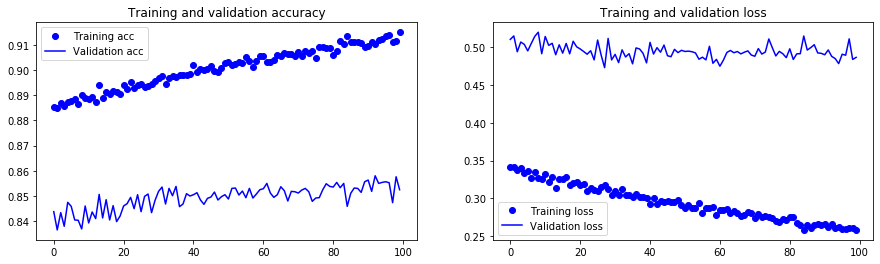

Test acc: 89.393 Val acc: 85.799 (At iteration 92) final training acc: 91.495

--------------------- Cross_subject_greedy_pose ---------------------------------------------


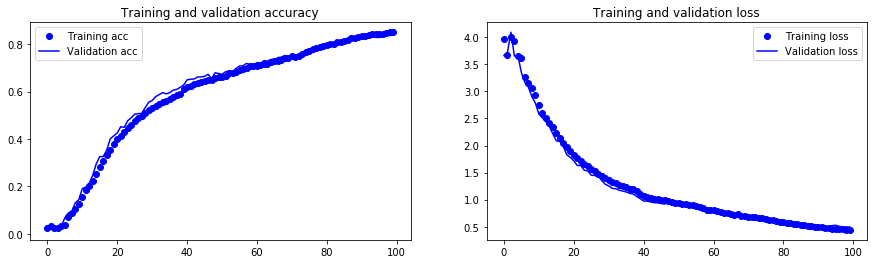

Test acc: 80.882 Val acc: 84.115 (At iteration 97) final training acc: 84.989

##################### det-4L-cuda-rimoz_0-3BAR-norm-drop-0,1 - 84.919 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


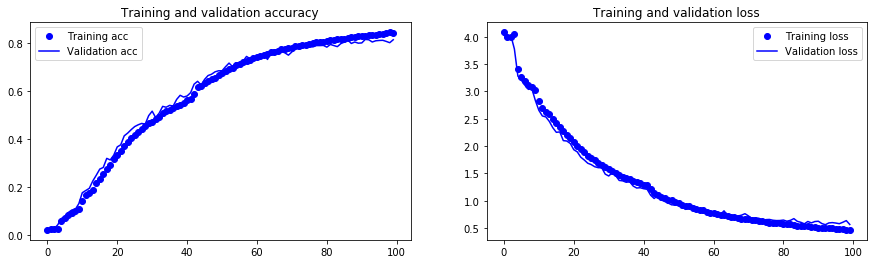

Test acc: 90.327 Val acc: 81.435 (At iteration 91) final training acc: 84.424

--------------------- Cross_subject_greedy_pose ---------------------------------------------


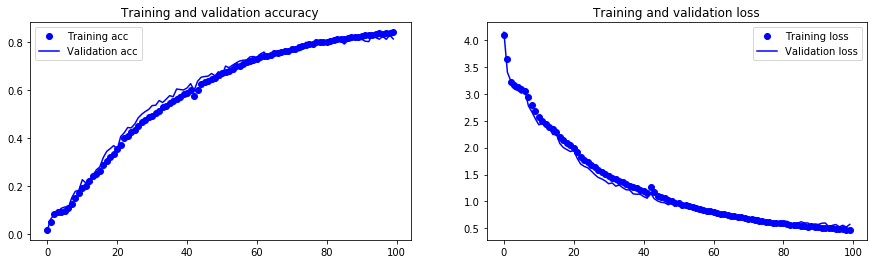

Test acc: 79.511 Val acc: 83.085 (At iteration 93) final training acc: 84.121

##################### det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15 - 84.720 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


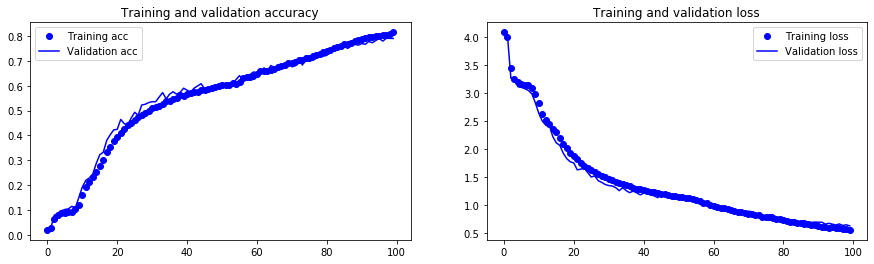

Test acc: 90.359 Val acc: 79.061 (At iteration 97) final training acc: 81.524

--------------------- Cross_subject_greedy_pose ---------------------------------------------


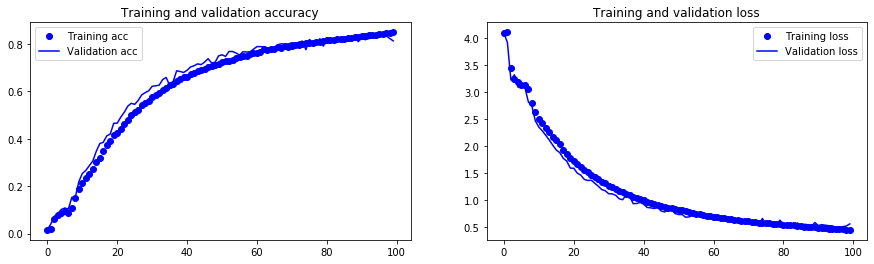

Test acc: 79.082 Val acc: 83.532 (At iteration 95) final training acc: 84.868

##################### det-3L-cuda-HU_155-rimoz_0-3BAR-norm-drop-0,15-reg-0,0001 - 84.671 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


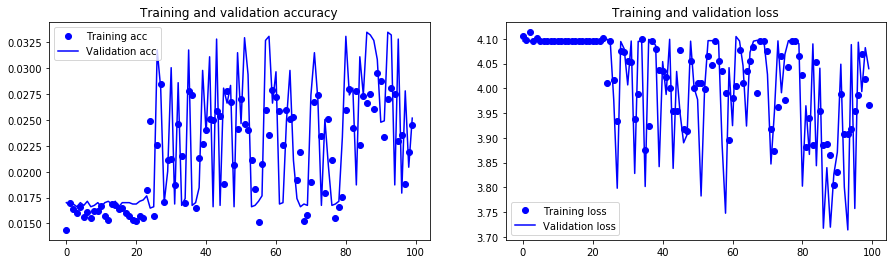

Test acc: 88.581 Val acc: 3.349 (At iteration 86) final training acc: 2.950

--------------------- Cross_subject_greedy_pose ---------------------------------------------


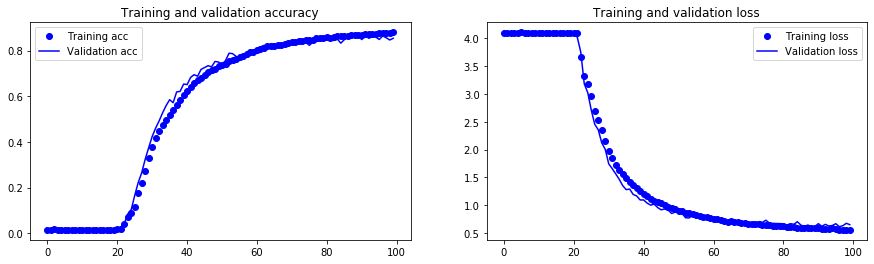

Test acc: 80.761 Val acc: 86.471 (At iteration 91) final training acc: 88.008

##################### det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05-MIN_LOSS - 84.608 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


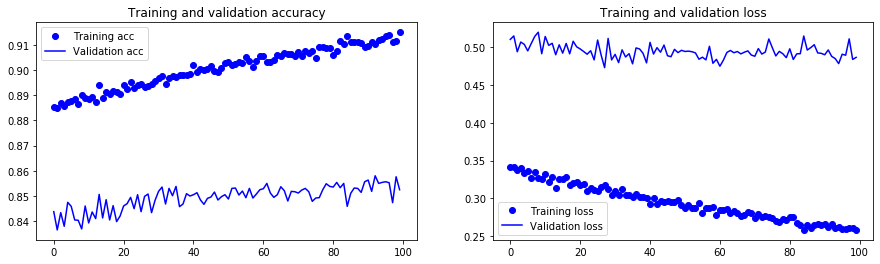

Test acc: 88.993 Val acc: 85.799 (At iteration 92) final training acc: 91.495

--------------------- Cross_subject_greedy_pose ---------------------------------------------


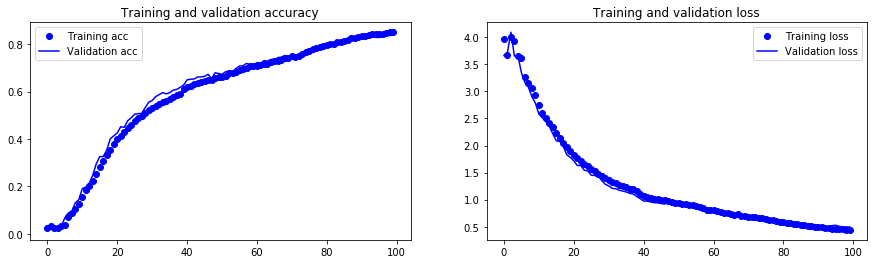

Test acc: 80.223 Val acc: 84.115 (At iteration 97) final training acc: 84.989

##################### det-3L-cuda-HU_155-rimoz_0-3BAR-norm-drop-0,15-reg-0,0001-MIN_LOSS - 84.584 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


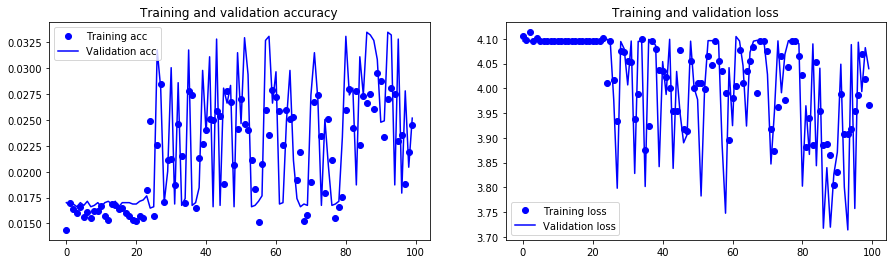

Test acc: 88.497 Val acc: 3.349 (At iteration 86) final training acc: 2.950

--------------------- Cross_subject_greedy_pose ---------------------------------------------


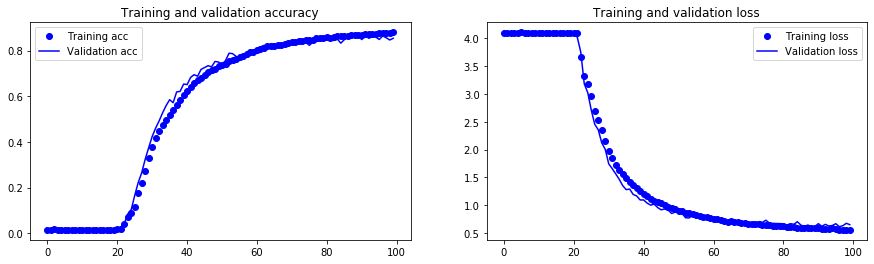

Test acc: 80.670 Val acc: 86.471 (At iteration 91) final training acc: 88.008

##################### det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15-MIN_LOSS - 84.496 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


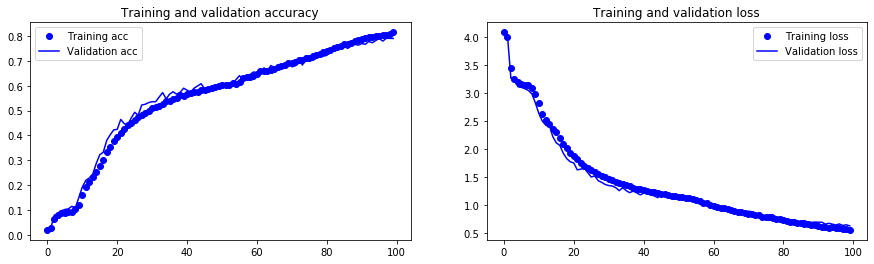

Test acc: 89.831 Val acc: 79.061 (At iteration 97) final training acc: 81.524

--------------------- Cross_subject_greedy_pose ---------------------------------------------


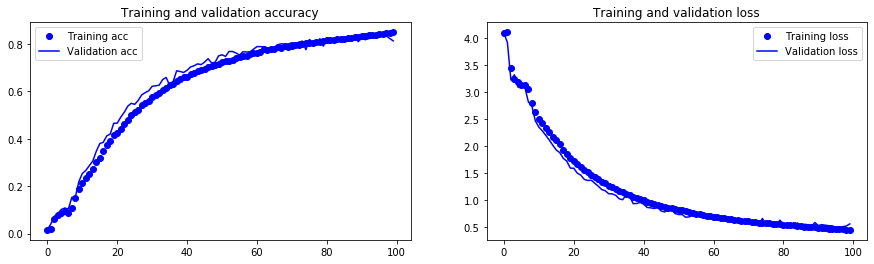

Test acc: 79.161 Val acc: 83.532 (At iteration 95) final training acc: 84.868

##################### det-4L-cuda-rimoz_0-3BAR-norm-drop-0,05 - 84.266 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


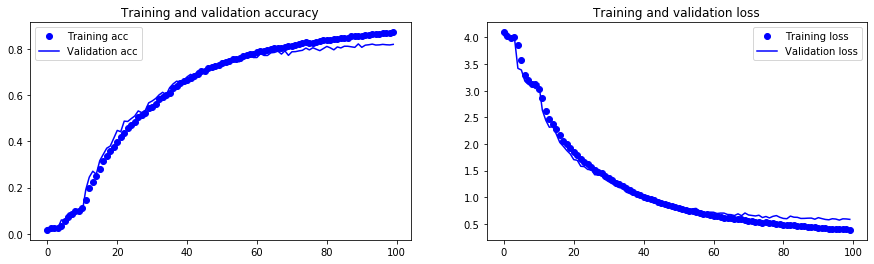

Test acc: 89.082 Val acc: 82.068 (At iteration 89) final training acc: 87.104

--------------------- Cross_subject_greedy_pose ---------------------------------------------


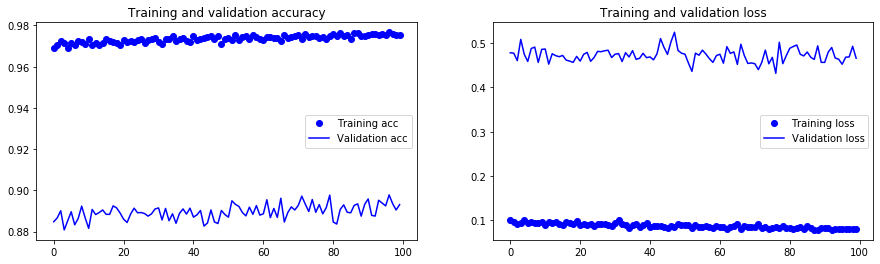

Test acc: 79.450 Val acc: 89.782 (At iteration 96) final training acc: 97.672

##################### det-4L-cuda-rimoz_0-3BAR-norm-drop-0,2 - 83.909 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


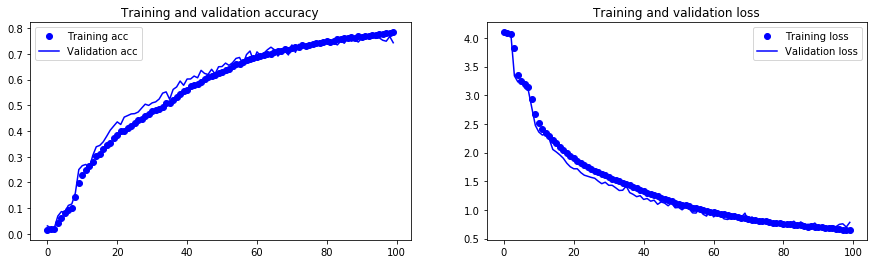

Test acc: 89.008 Val acc: 77.255 (At iteration 91) final training acc: 78.379

--------------------- Cross_subject_greedy_pose ---------------------------------------------


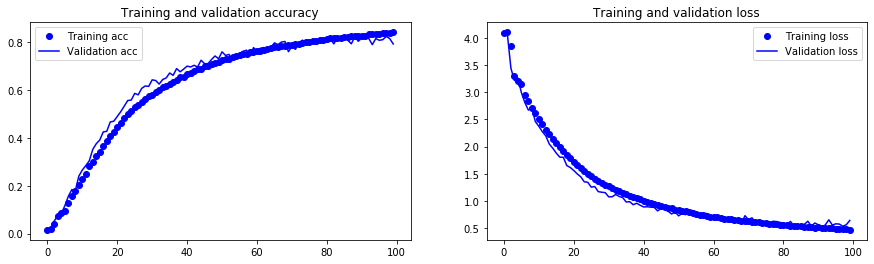

Test acc: 78.810 Val acc: 82.515 (At iteration 91) final training acc: 84.242

##################### det-2L-cuda-HU_368-LR_0,004-OFF_0,002-rimoz_0-3BAR-norm-drop-0,15 - 83.863 ######################
--------------------- Cross_view_greedy_pose ---------------------------------------------


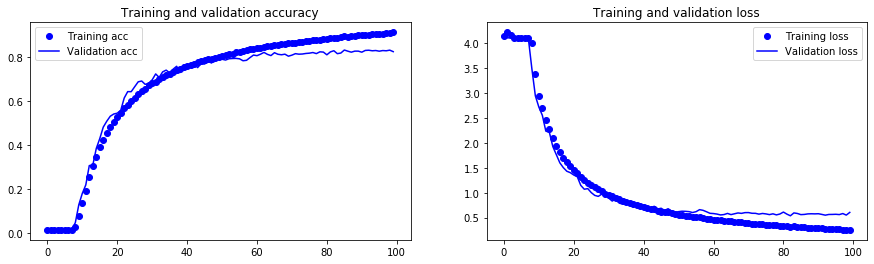

Test acc: 88.444 Val acc: 83.281 (At iteration 85) final training acc: 91.356

--------------------- Cross_subject_greedy_pose ---------------------------------------------


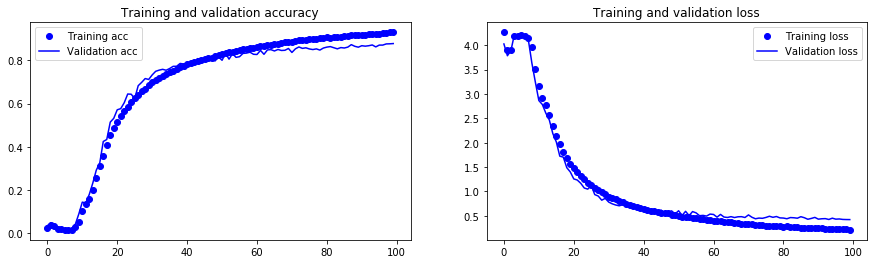

Test acc: 79.281 Val acc: 87.760 (At iteration 99) final training acc: 92.994



In [10]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
import numpy as np
from os.path import basename #, exists
from parse import parse

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/" 

################ FROM PREVIOUS GLOBAL RESULT ################
for result in globalResults[:10]:
    print("##################### {} - {:.3f} ######################".format(cleanForExcel(result["model_name"]),result["avg"]*100))
    
    
#     folder_name_format = "S{:3d}C{:3d}P{:3d}R{:3d}A{:3d}_rgb" #Setup-Camera-Performer-Replication-Action
#     def getConfigurationFromFolderPath(folderPath):
#     setup, camera, performer, replication, label = parse.parse(folder_name_format,basename(folderPath))
    
    foldersToShow = [parse("{}_test_acc",f) for f in list(result.keys()) if parse("{}_test_acc",f) != None]
    for folder in foldersToShow:
        folder = folder[0]
        
        if result[folder+"_test_acc"] == 0:
            continue
            
        print("---------------------",folder,"---------------------------------------------")
            
        historyPath = SAVED_MODEL_FOLDER+folder+"/"+result["model_name"]+".pickle"
        historyPath = historyPath.replace("-MIN_LOSS.pickle",".pickle")
        with open(historyPath,"rb") as file_in:
            r = pickle.load(file_in)

        model_history = r["history"]
        
        if isinstance(model_history, dict):
            acc = model_history['acc']
            val_acc = model_history['val_acc']
            loss = model_history['loss']
            val_loss = model_history['val_loss']
        else:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']
            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            
        
        max_iter = 100
        acc = acc[:max_iter]
        val_acc = val_acc[:max_iter]
        loss = loss[:max_iter]
        val_loss = val_loss[:max_iter]


        epochs = range(len(acc))

        plt.figure(figsize = (15,4))
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, acc, 'bo', label='Training acc')
        ax1.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        ax1.legend()

        #     plt.figure()
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(epochs, loss, 'bo', label='Training loss')
        ax2.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        ax2.legend()

        plt.show()
        test_acc = result[folder+"_test_acc"]*100
        max_val_acc = max(val_acc)*100
        i_val_acc = np.argmax(val_acc)
        training_acc = max(acc)*100
        print("Test acc: {:.3f} Val acc: {:.3f} (At iteration {}) final training acc: {:.3f}".format(test_acc,max_val_acc,i_val_acc,training_acc))
        if "loaded_from" in r.keys():
            print("Loaded from:", cleanForExcel(r["loaded_from"]))
        print("")

In [ ]:
folder[0]

In [ ]:
list(globalResults[0].keys())[1:3]

In [ ]:
from parse import parse
result = globalResults[0]
[parse("{}_test_acc",f) for f in list(result.keys()) if parse("{}_test_acc",f) != None]
# [f for f in list(result.keys())[1:3]]

In [ ]:
historyPath

### Visualize missclassified

In [ ]:
import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = None):
    plt.figure(figsize = (25,35))
    ax1 = plt.subplot(2, 1, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(2, 1, 2)
    
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()

In [ ]:
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# label_order = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
#                '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
#                '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
#                '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
#                '6', '60', '7', '8', '9']


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  
# SAVED_MODEL_FOLDER += "Cross_subject_mini/" 
SAVED_MODEL_FOLDER += "Cross_view/"  
# SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
result = loadedResults[0]

y_val_pred = result["y_val_pred"]
y_val_true = result["y_val_true"]
y_test_pred = result["y_test_pred"]
y_test_true = result["y_test_true"]
val_acc = result["val_acc"]
test_acc = result["test_acc"]
print("Val acc:",val_acc)
print("Test acc:",test_acc)

# import pandas as pd
# y_actu_val = pd.Series(y_val_true, name='Actual')
# y_pred_val = pd.Series(y_val_pred, name='Predicted')
# conf_mat_val = pd.crosstab(y_actu_val, y_pred_val, rownames=['Actual'], colnames=['Predicted']
# #                            , margins=True
#                           )

# y_actu_test = pd.Series(y_test_true, name='Actual')
# y_pred_test = pd.Series(y_test_pred, name='Predicted')
# conf_mat_test = pd.crosstab(y_actu_test, y_pred_test, rownames=['Actual'], colnames=['Predicted']
# #                             , margins=True
#                            )

conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

# # normalize
# conf_mat_val = conf_mat_val / conf_mat_val.sum(axis=1)
# conf_mat_test = conf_mat_test / conf_mat_test.sum(axis=1)

labels = range(1,len(conf_mat_val[0])+1)
plotConfusionMatrixes(conf_mat_val,conf_mat_test,labelString=labels)

length = len(conf_mat_test)

till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_SUBJECT
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_VIEW
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [14]:
view = [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23] # toughest cross_view
subj = [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57] # toughest cross_subject
subj.sort()
view.sort()
print("subj =", subj)
print("view =", view)

subj = [10, 11, 12, 16, 17, 29, 30, 31, 32, 34, 53, 57]
view = [10, 11, 12, 16, 17, 23, 29, 30, 34, 49, 53, 57]


## Re-evaluating model

In [41]:
import dill
import pickle
import numpy as np
from keras import models,layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Concatenate , Dense
from keras.models import Model,load_model
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
from os import scandir
from os.path import exists
import shutil 

DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
fullModelNameToEvaluate = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0"

# folder_to_evaluate = "Cross_view/"  
folder_to_evaluate = "Cross_view_mini/"  
# folder_to_evaluate = "Cross_subject/"

completeFolderPath = SAVED_MODEL_FOLDER+folder_to_evaluate


assert exists(completeFolderPath+"summaryResults-Copy1.pickle")
print("Loading previous results...")
with open(completeFolderPath+"summaryResults-Copy1.pickle","rb") as handle:
    results = pickle.load(handle)

# results.sort(key=lambda x : x["test_acc"],reverse=True)

accessoriesPath = completeFolderPath+fullModelNameToEvaluate+".pickle"

print("Loading accessories:",accessoriesPath)
with open(accessoriesPath,"rb") as handle:
    accessories = pickle.load(handle)
            
print("Loading functions...")
loaded_specific_functions = [dill.loads(x) for x in accessories["spec_fun_DILL"]]

## SPECIFIC FUNCTIONS
specificFunctions = []
for elem in loaded_specific_functions:
    if callable(elem):
        specificFunctions.append(elem)
    elif not callable(elem):
        specificFunctions.append(elem[0])
                

if folder_to_evaluate.endswith("Cross_subject/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
if folder_to_evaluate.endswith("Cross_subject_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"
else:
    raise Exception("folder not recognised")
    
### LOADING DATASET ###
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                               val_set, 
                                                                               test_set,  
                                                                               specificFunctions)
encodingLabels = [int(i) for i in encodingLabels]

model = load_model(completeFolderPath+fullModelNameToEvaluate+".h5")
### EVALUATING MODEL ###      
val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))


minLossModelName = "{}-min_val_loss.hdf5".format(completeFolderPath+fullModelNameToEvaluate)
model_minLoss = load_model(minLossModelName)
val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

### SAVING RESULTS ###
newEvaluation = {"val_acc": val_acc, 
                "test_acc": test_acc, 
                "model_name": fullModelNameToEvaluate, 
                "y_val_true": y_val_true,
                "y_val_pred": y_val_pred,
                "y_test_true": y_test_true,
                "y_test_pred": y_test_pred,

                "val_acc_minLoss": val_acc_minLoss, 
                "test_acc_minLoss": test_acc_minLoss, 
                "y_val_pred_minLoss": y_val_pred_minLoss,
                "y_test_pred_minLoss": y_test_pred_minLoss
               }

previousResult = [v for v in results
     if v["model_name"] == fullModelNameToEvaluate]
isPreviousResult = np.array(results) == previousResult
indexPreviousResult = np.array(range(len(results)))[isPreviousResult]
if len(indexPreviousResult) == 0:
    print("model evaluated for the first time")
    results.append(newEvaluation)
else:
    print("substituting evaluation for the model")
    results[indexPreviousResult[0]] = newEvaluation



print("Dumping results...")
with open(completeFolderPath+"summaryResults.pickle","wb") as handle:
    pickle.dump(results, handle)

print("DONE!")


Loading previous results...
Loading accessories: /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0.pickle
Loading functions...
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the CENTER of each VIDEO
Adapting the data to the CENTER of each VIDEO
Ada

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Visualize nextFrameResults

In [32]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_MINI-dataset.pickle"

train_set, val_set, test_set = getData(datasetName)

train_set[0] = removeZerosFromDataset(train_set[0])
# train_set[0] = relativeToNextFrameBuilder(11)(train_set[0])
# train_set[0] = relativeToUpperMiddleBottomCentersOfVideo(train_set[0])
train_set[0] = cumulativeDifferences(train_set[0])
# train_set[0] = normalizeVideosXYInpid(train_set[0])
train_set[0] = normalizeVideos(train_set[0])

# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
print("DONE!")

train_set shape: (6451,)
train_set zero elements: 18496/19641018 (0.094%)
val_set shape: (1613,)
val_set zero elements: 6358/4906268 (0.13%)
test_set shape: (3312,)
test_set zero elements: 5032/10836820 (0.046%)
removing zeros from dataset
Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames
normalising EACH VIDEO, considering x and y TOGETHER
DONE!


In [34]:
from random import randint
video_ids = [randint(0,len(train_set[0])) for i in range(15)]

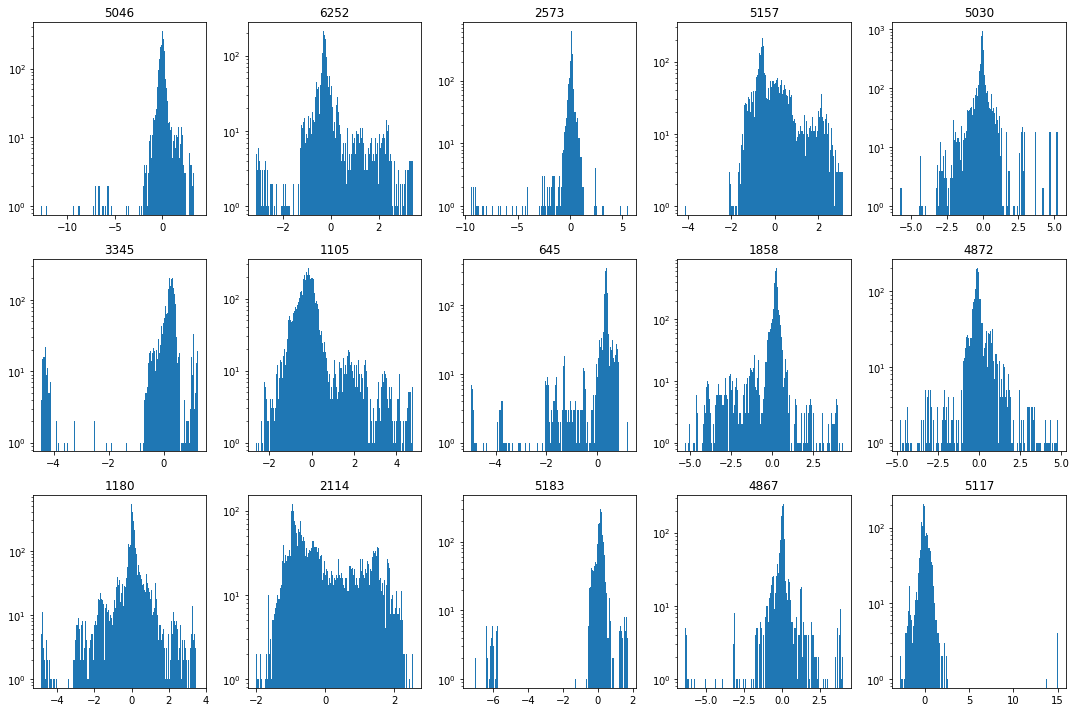

In [35]:
# CUMULATIVE DIFFERENCES
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

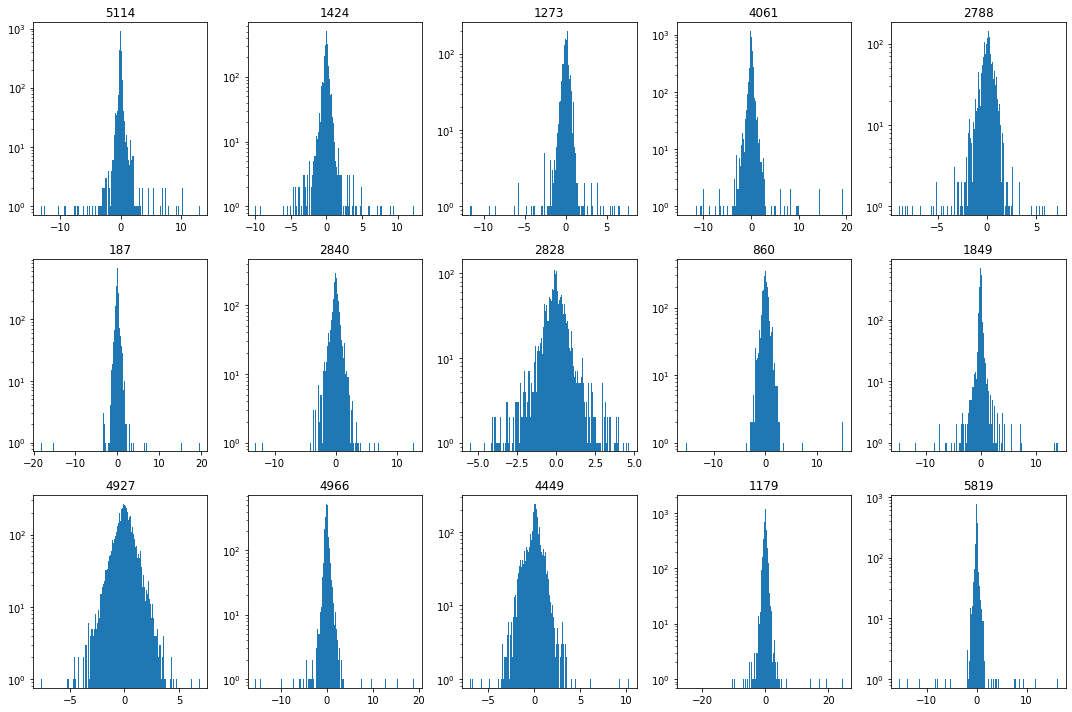

In [255]:
# NEXT FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

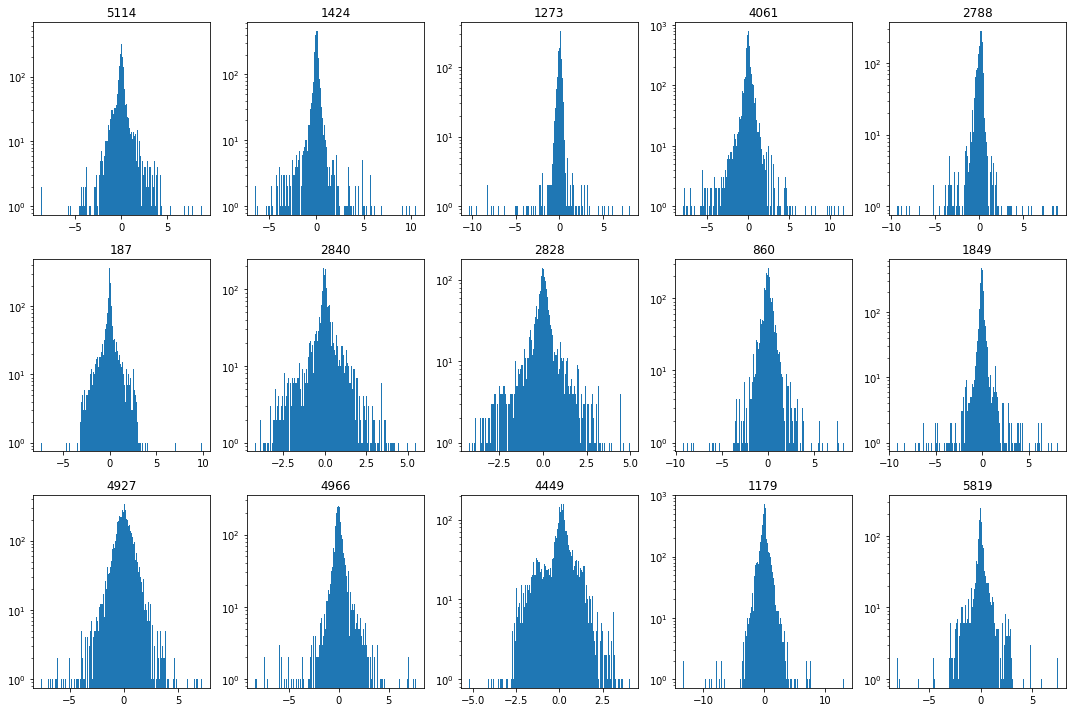

In [259]:
# NEXT 5 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

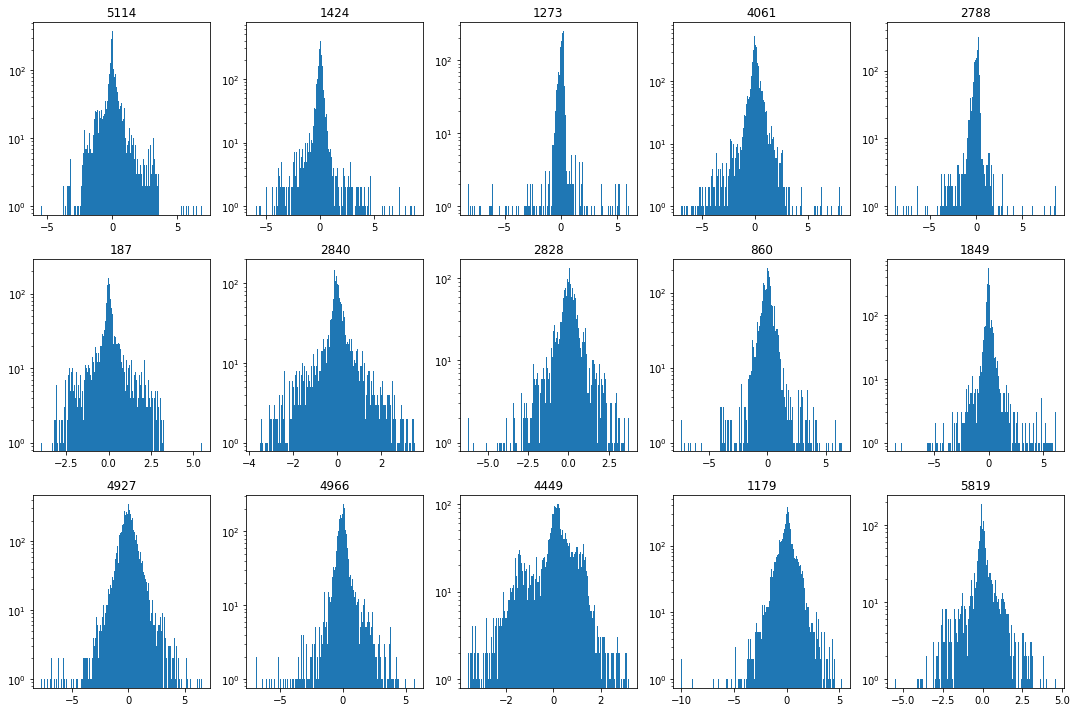

In [261]:
# NEXT 11 FRAME nomalizing INDIPENDENTLY
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

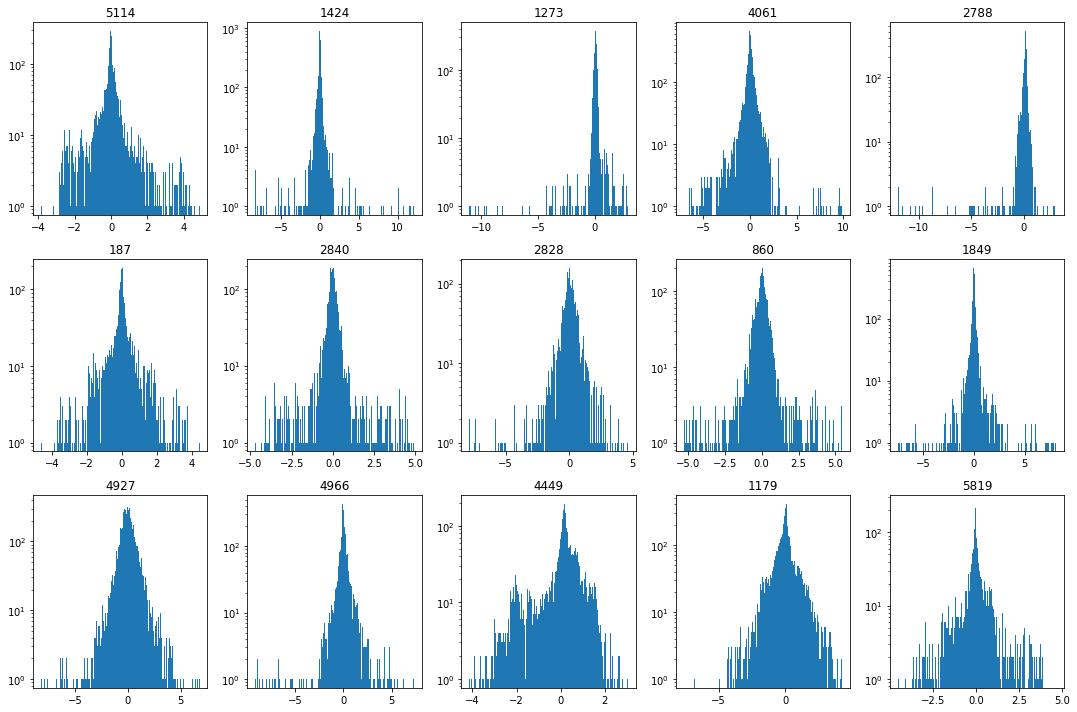

In [267]:
# NEXT 11 FRAME nomalizing TOGETHER
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

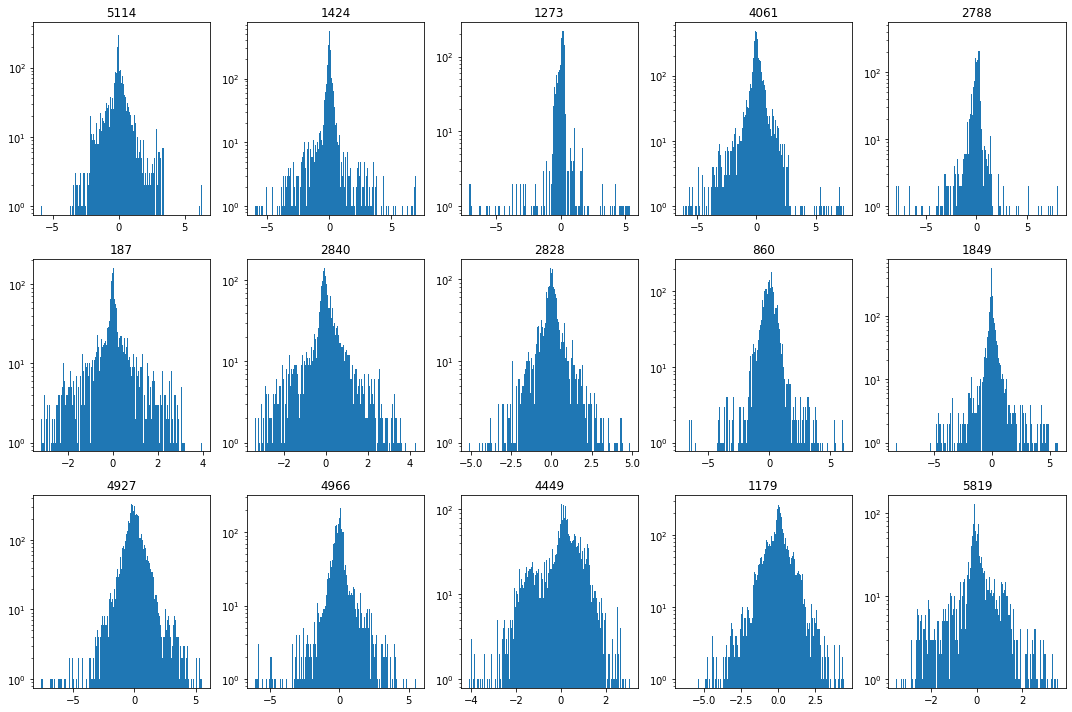

In [263]:
# NEXT 15 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

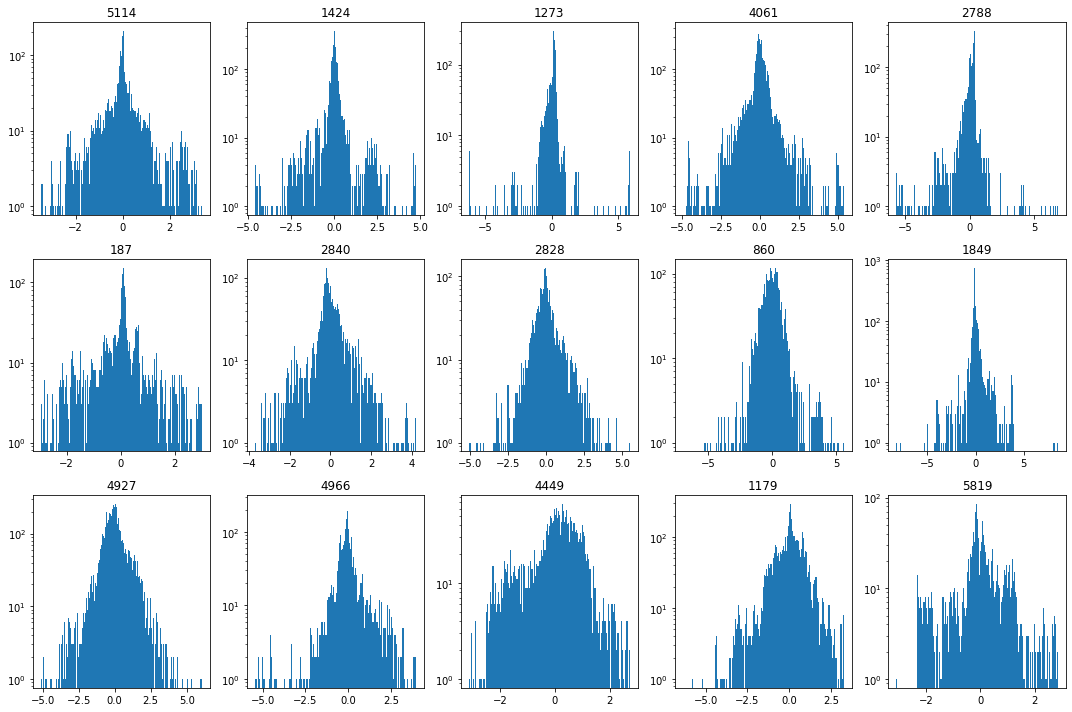

In [265]:
# NEXT 30 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

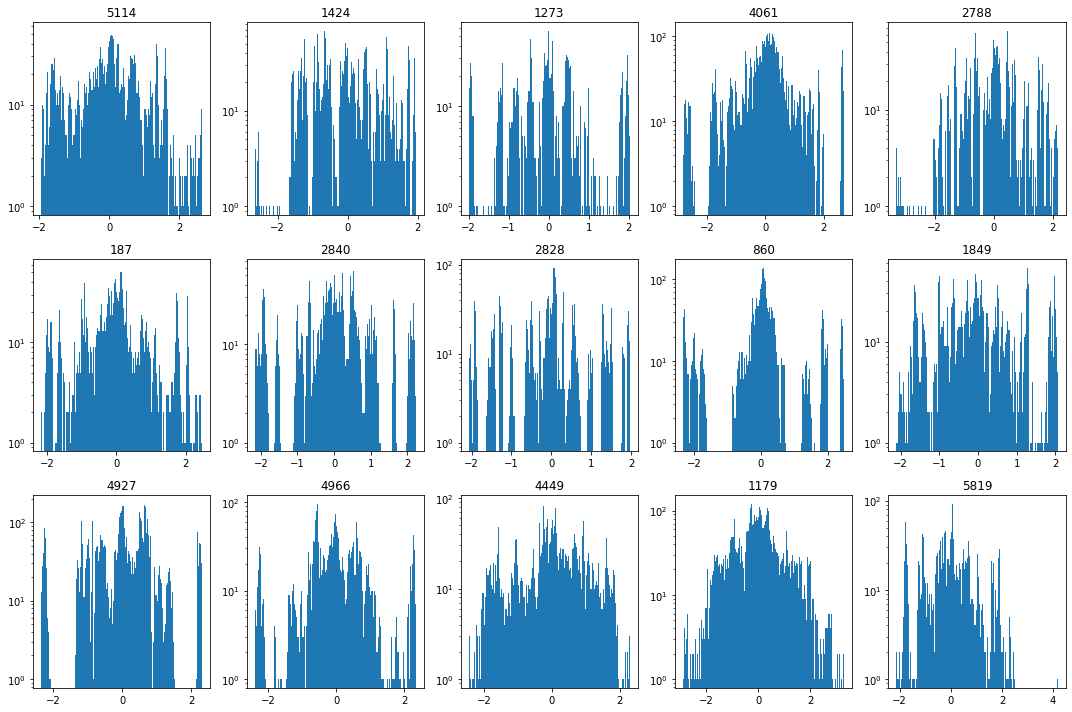

In [277]:
# 3BAR
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

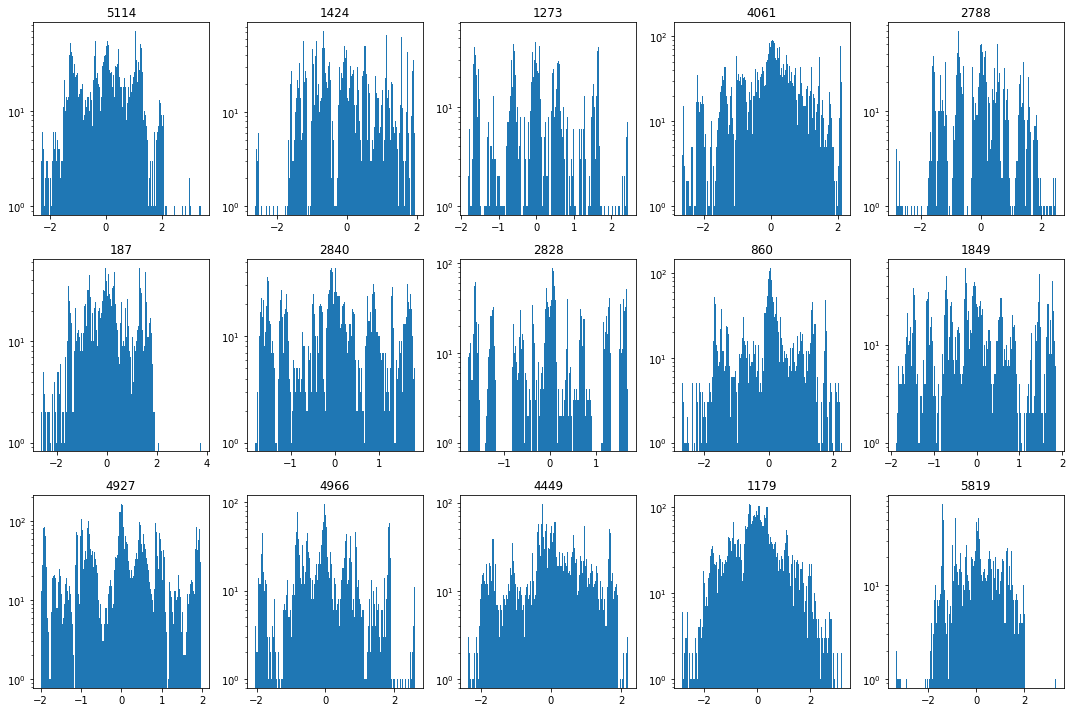

In [275]:
# 3BAR INDIP
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

## CLEAN Results

In [112]:
#remove last element of summary result

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

print("Removing",loadedResults[-1]['model_name'])
print ("From",SAVED_MODEL_FOLDER+"summaryResults.pickle")

# loadedResults = loadedResults[:-1]
# with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
#             pickle.dump(loadedResults, handle)

Removing keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo5CentersNTURGBofVideo-drop-0.1-rec_drop-0.1-norm
From /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Senesi/summaryResults.pickle


## Removing accessories file for low results

In [5]:
from os.path import isfile, isdir, join, exists,getsize,basename
from os import scandir
import pickle

NUMBER_OF_BEST_MODEL_TO_SAVE = 20

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
SAVED_MODEL_FOLDER += "Cross_view_mini/"
# SAVED_MODEL_FOLDER += "Cross_subject_mini/"


accessoryFileList = [f.path for f in scandir(SAVED_MODEL_FOLDER) 
                       if f.path.endswith(".pickle") 
                       and "summaryResult" not in basename(f)]

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"], reverse=True)
assert NUMBER_OF_BEST_MODEL_TO_SAVE > 10
bestModels = [r['model_name'] for r in loadedResults[:NUMBER_OF_BEST_MODEL_TO_SAVE]]

for accessoryFile in accessoryFileList:
    modelNameToCheck = basename(accessoryFile).replace(".pickle","")
    if modelNameToCheck not in bestModels:
        print("Removing",accessoryFile)
        !rm $accessoryFile

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0.5-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.5-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.05-rec_drop-0.05.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideos-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-normalizeVideos-drop-0.1-rec_drop-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.pickle


# AREA TEST

## Testing relativeToNextFrameFunction

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


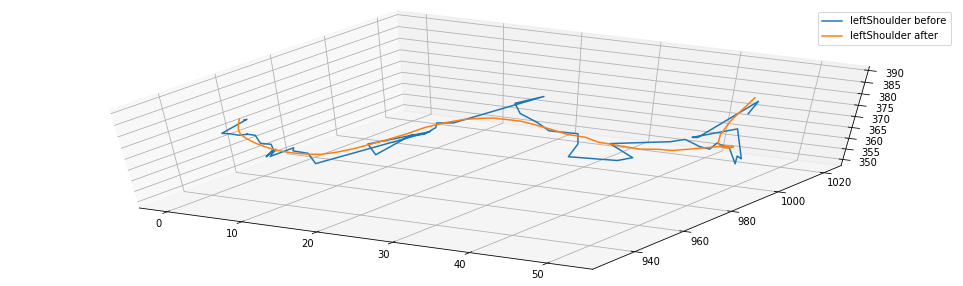

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

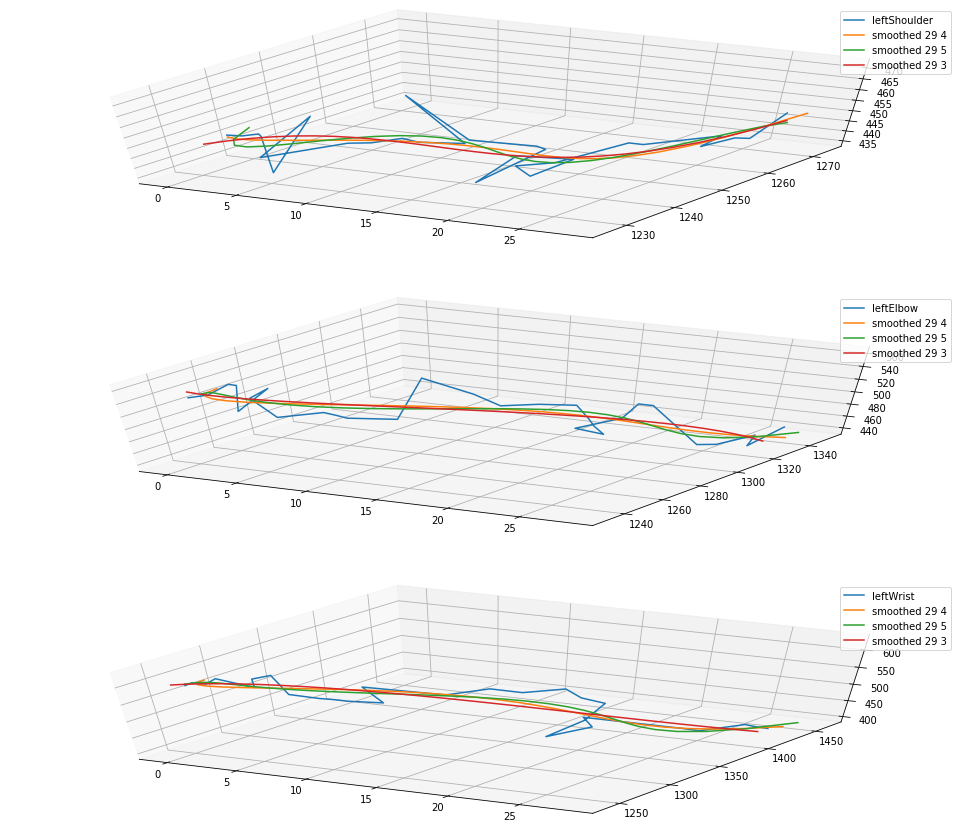

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

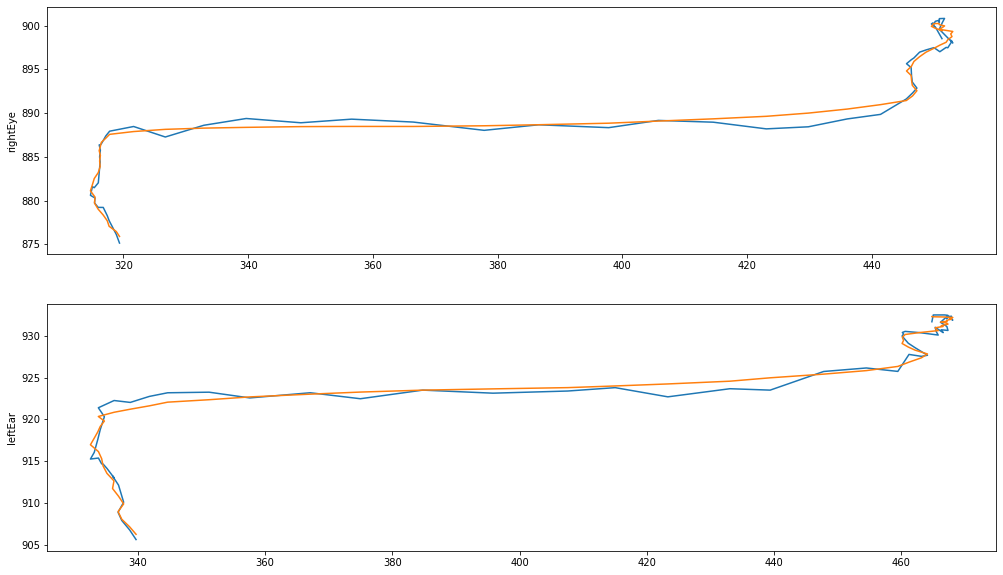

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

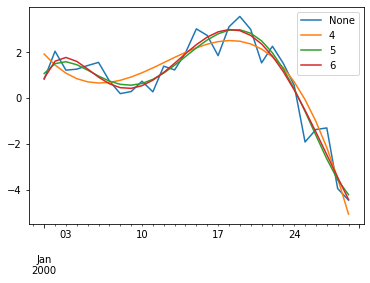

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()